In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import colors
import matplotlib
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm
import pingouin as pg
from adjustText import adjust_text
from scipy.spatial import ConvexHull, Delaunay
# from shapely.geometry import Point, Polygon
from pybaseball import playerid_reverse_lookup

%matplotlib inline 

In [2]:
seed = 1126

### Data Preprocessing

In [3]:
## Define Strikezone
strike_zone = pd.DataFrame({
  'PlateLocSide': [-0.708, -0.708, 0.708, 0.708, -0.708],
  'PlateLocHeight': [1.5, 3.5, 3.5, 1.5, 1.5]
})

## Add strike zone to Plot
def draw_line(axis, alpha_spot = 1, catcher_p = True):
    axis.plot(strike_zone['PlateLocSide'], strike_zone['PlateLocHeight'], color = 'black', linewidth = 1.3, zorder = 3, alpha = alpha_spot,)

In [4]:
colour_palette = ['#FFB000','#648FFF','#785EF0',
                  '#DC267F','#FE6100','#3D1EB2','#894D80','#16AA02','#B5592B','#A3C1ED']

In [5]:
data_2021 = pd.read_csv('./data/2021_data.csv')
data_2022 = pd.read_csv('./data/2022_data.csv')
data_2023 = pd.read_csv('./data/2023_data.csv')
data_2024 = pd.read_csv('./data/2024_data.csv')

In [6]:
## Define a dictionary to group outcomes together
des_dict = {'ball':'ball',
'hit_into_play':'hit_into_play',
'called_strike':'called_strike',
'foul':'foul',
'swinging_strike':'swinging_strike',
'blocked_ball':'ball',
'swinging_strike_blocked':'swinging_strike',
'foul_tip':'swinging_strike',
'foul_bunt':'foul',
'hit_by_pitch':'hit_by_pitch',
'pitchout':'ball',
'missed_bunt':'swinging_strike',
'bunt_foul_tip':'swinging_strike',
'foul_pitchout':'foul',}

## Define a dictionary to group events together
ev_dict = {
 'single':'single',
 'walk':'walk',
 np.nan:np.nan,
 'strikeout':'strikeout',
 'field_out':'field_out',
 'force_out':'field_out',
 'double':'double',
 'hit_by_pitch':'hit_by_pitch',
 'home_run':'home_run',
 'grounded_into_double_play':'field_out',
 'fielders_choice_out':'field_out',
 'fielders_choice':'field_out',
 'field_error':'field_out',
 'double_play':'field_out',
 'sac_fly':'field_out',
 'strikeout_double_play':np.nan,
 'triple':'triple',
 'sac_bunt':'field_out',
 'catcher_interf':np.nan,
 'sac_fly_double_play':'field_out',
 'triple_play':'field_out',
 'other_out':'field_out',
 'wild_pitch':'wild_pitch',
 'sac_bunt_double_play':'field_out',
 'truncated_pa': np.nan}

In [7]:
swing_in = ['foul_bunt','foul','hit_into_play','swinging_strike', 'foul_tip', 'swinging_strike_blocked','missed_bunt','bunt_foul_tip', 'foul_pitchout']

In [8]:
## Define a function which applies relevant transformations
def df_clean(df):
    # Create a new column with the grouped decisions
    df['des_new'] = df.description.map(des_dict)
    # Create a new column with the grouped events
    df['ev_new'] = df.loc[df['des_new'] == 'hit_into_play', 'events'].map(ev_dict)
    df.loc[df['des_new'] == 'hit_into_play', 'des_new'] = df.loc[df['des_new'] == 'hit_into_play', 'ev_new']
    df = df.dropna(subset = ['des_new'])
    # Filter rare cases
    df = df[(df.strikes <= 2) & (df.balls <= 3)]
    df.loc[:, 'count'] = df.loc[:, 'balls'].astype(str) + '-' + df.loc[:, 'strikes'].astype(str)
    df['count'] = df['count'].astype("category")
    # Create a dataset with average run expectancy 
    # given outcome and count
    des_values = df.groupby(['des_new', 'count'], observed = False)['delta_run_exp'].mean()
    # Merge the average run expectancies to the dataset
    df = df.merge(des_values, left_on = ['des_new', 'count'], right_on = ['des_new', 'count'], suffixes = ['', '_mean'])
    # Add a binary columns for swings
    conditions_swings = [(df['description'].isin(swing_in))]
    choices_swings = [True]
    df['swing'] = np.select(conditions_swings, choices_swings, default = 0)
    
    return df

## Transform the Datasets
processed_data_2021 = df_clean(df = data_2021).dropna(subset = ['pitch_type'])
processed_data_2022 = df_clean(df = data_2022).dropna(subset = ['pitch_type'])
processed_data_2023 = df_clean(df = data_2023).dropna(subset = ['pitch_type'])
processed_test_data = df_clean(df = data_2024).dropna(subset = ['pitch_type'])

In [9]:
def get_convex_hull(df):
    df = df.dropna(subset = 'launch_speed').reset_index(drop = True)

    if df.shape[0] < 60:
        return None # Convex hull not defined for < 3 points

    threshold = np.percentile(df['launch_speed'].values, 95)
    points = np.stack((df.loc[df['launch_speed'] >= threshold, 'plate_x'].values, df.loc[df['launch_speed'] >= threshold, 'plate_z'].values), axis = 1)
    
    hull = ConvexHull(points)
    return hull

In [10]:
def is_inside_hull(row):
    plate_x, plate_z, hull = row
    point = np.array([plate_x, plate_z])
    result = np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 0)

    return result

In [11]:
def add_nitro_zone(df):
    nitro_zone = df.loc[df['description'] == 'hit_into_play', :].groupby('batter')[['launch_speed', 'plate_x', 'plate_z']].apply(get_convex_hull)
    nitro_zone = nitro_zone.dropna().reset_index()
    nitro_zone.columns = ['batter', 'nitro_zone']
    df = df.merge(nitro_zone, on = 'batter')

    return df

In [12]:
processed_data_2021 = add_nitro_zone(processed_data_2021)
processed_data_2022 = add_nitro_zone(processed_data_2022)
processed_data_2023 = add_nitro_zone(processed_data_2023)
processed_test_data = add_nitro_zone(processed_test_data)

In [13]:
processed_data_2021.loc[:, 'in_nitro'] = processed_data_2021.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)
processed_data_2022.loc[:, 'in_nitro'] = processed_data_2022.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)
processed_data_2023.loc[:, 'in_nitro'] = processed_data_2023.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)
processed_test_data.loc[:, 'in_nitro'] = processed_test_data.loc[:, ['plate_x', 'plate_z', 'nitro_zone']].apply(is_inside_hull, axis = 1)

In [14]:
processed_train_data = pd.concat([processed_data_2021, processed_data_2022, processed_data_2023]).reset_index(drop = True)

In [15]:
print(processed_train_data.shape)
print(processed_test_data.shape) 

(2027439, 125)
(678107, 125)


### EDA

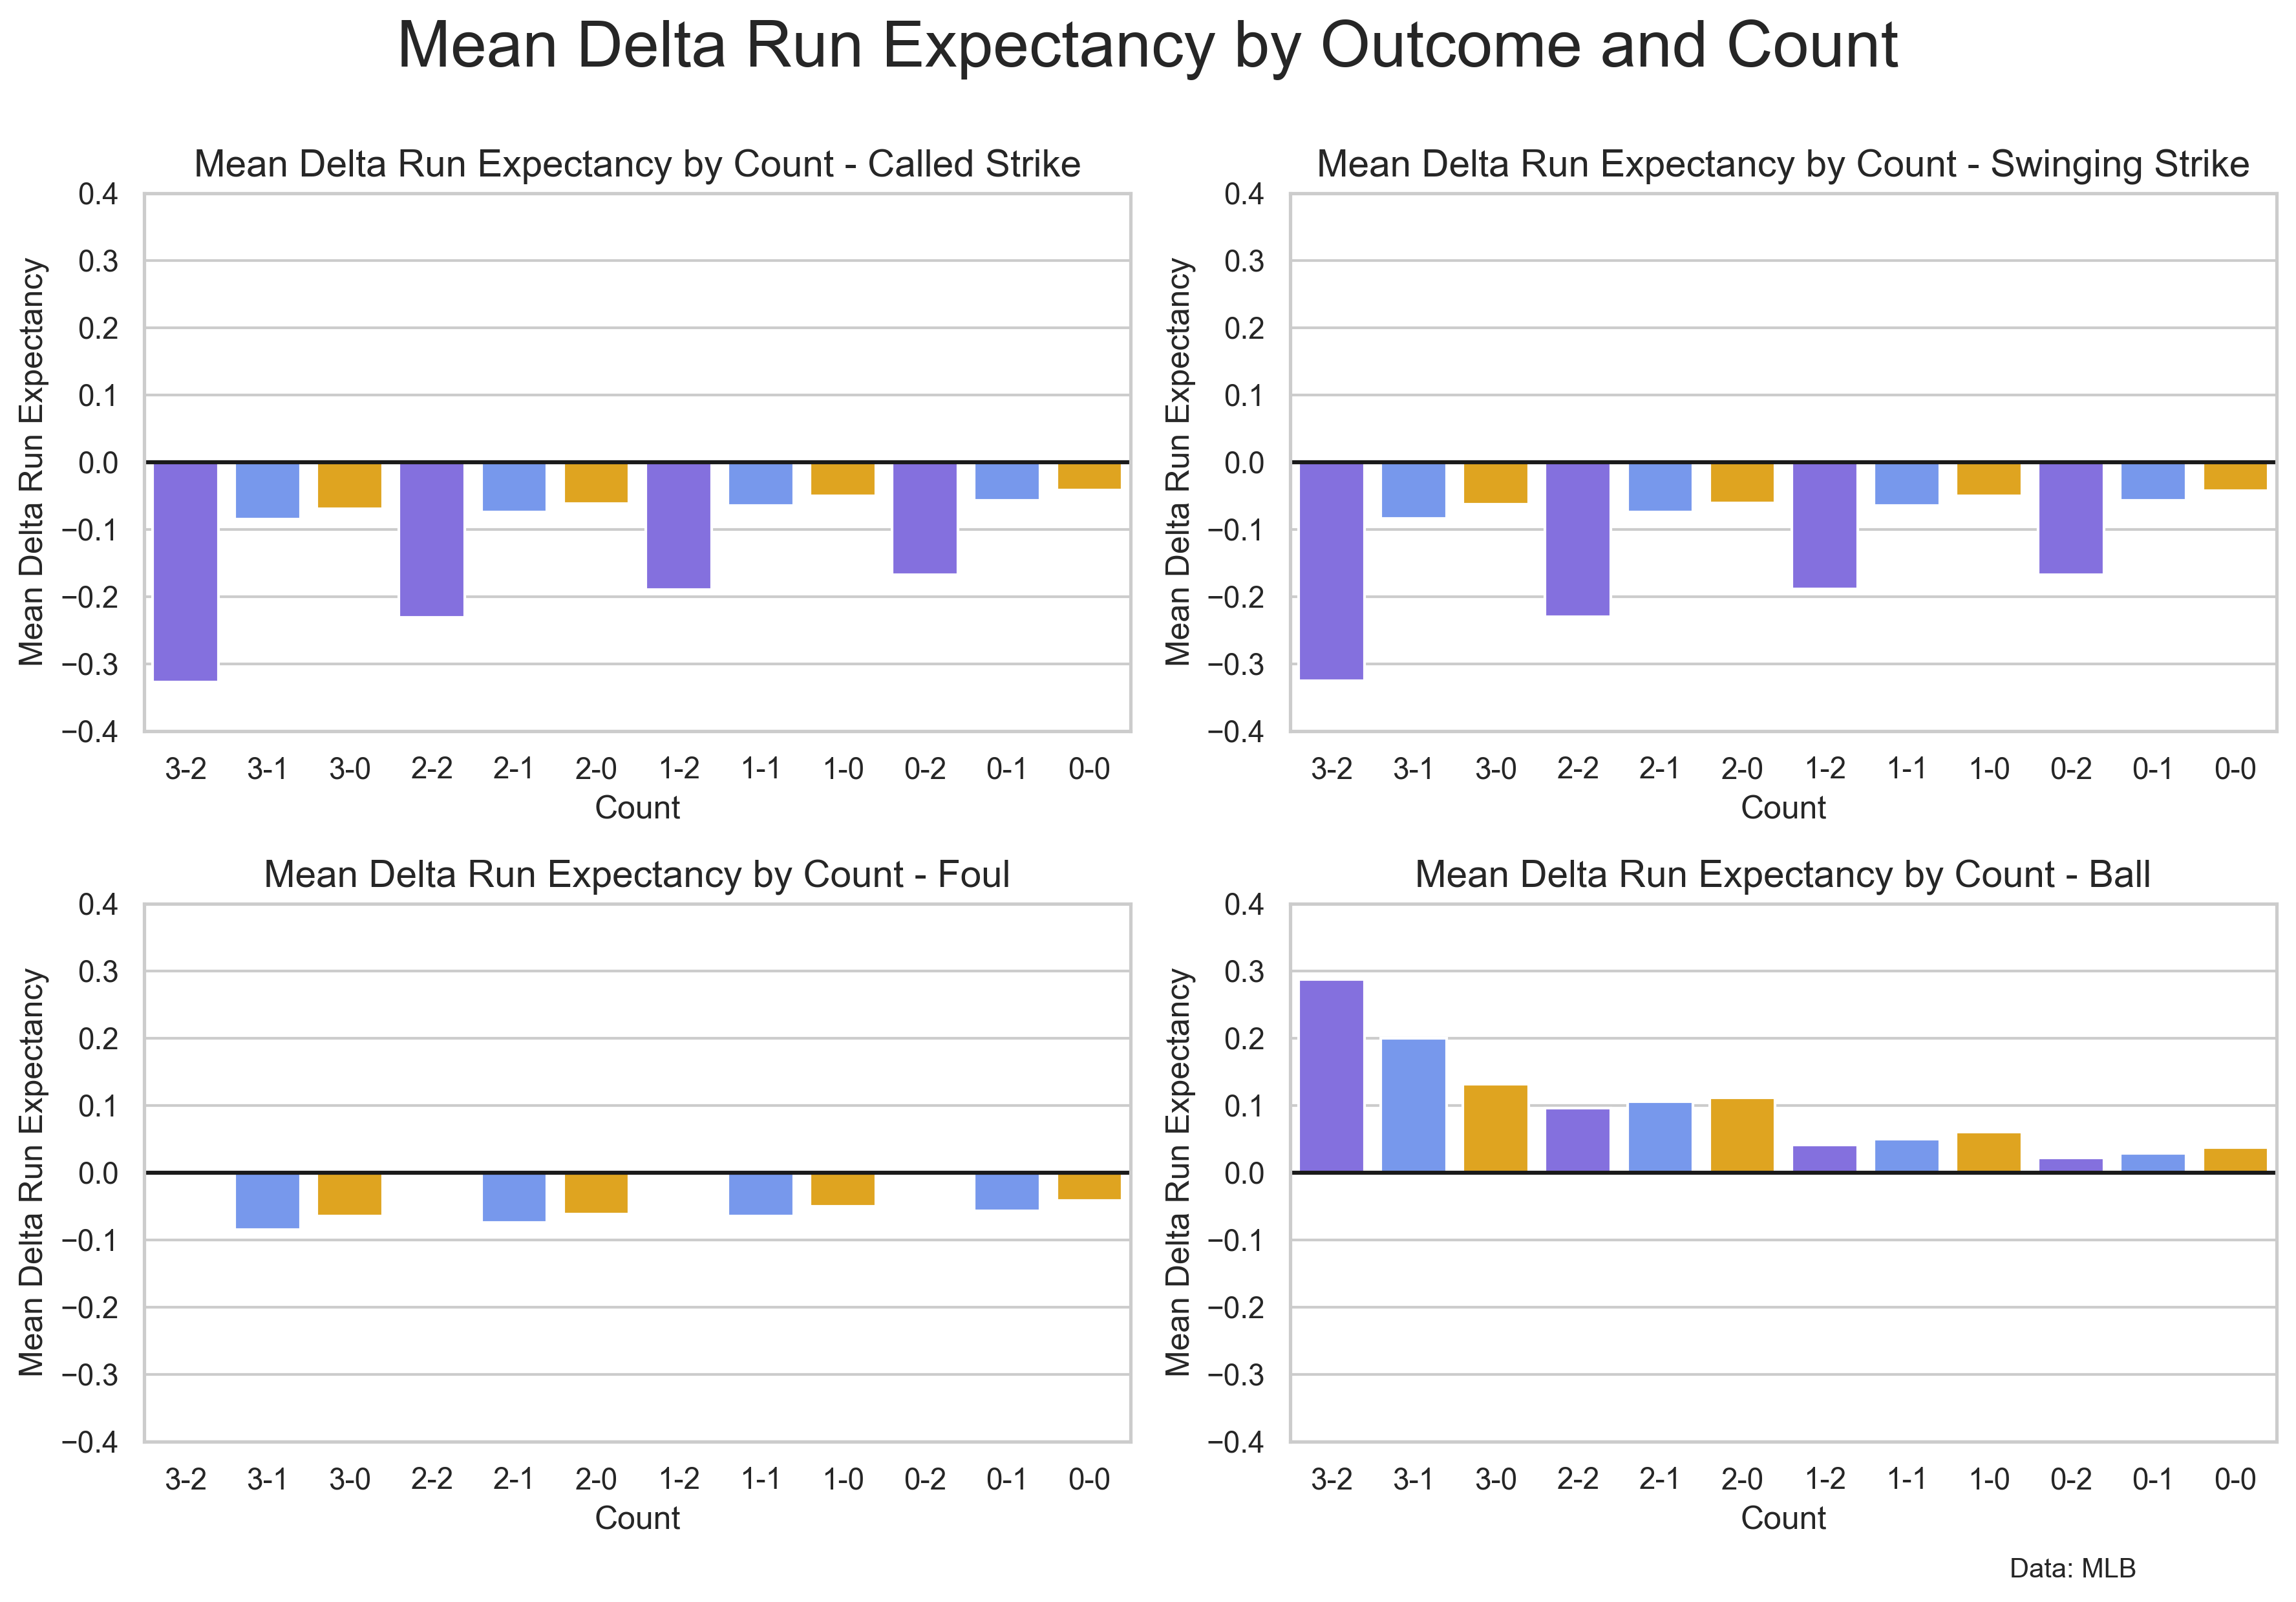

In [18]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_delta = ['swinging_strike', 'called_strike', 'foul', 'ball']
outcomes_df = processed_train_data.groupby(['des_new', 'strikes', 'balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df = outcomes_df[outcomes_df.des_new.isin(outcomes_delta)]
outcomes_df = outcomes_df[(outcomes_df.strikes <= 2) & (outcomes_df.balls <= 3)]
outcomes_df['count'] = outcomes_df.balls.astype(str) + '-' + outcomes_df.strikes.astype(str)
outcomes_df = outcomes_df.sort_values(['balls', 'strikes'], ascending = False)
 

outcome_titles = {'swinging_strike':'Swinging Strike',
'called_strike':'Called Strike',
'foul':'Foul',
'hit_into_play':'Hit Into Play',
'ball':'Ball'}


sns.set_theme(style = "whitegrid")

fig, ax = plt.subplots(2, 2, figsize = (12, 8), dpi = 300)

axs = ax.flatten()
for outx in range(0, outcomes_df.des_new.nunique()):
    
    sns.barplot(data = outcomes_df[outcomes_df.des_new == outcomes_df.des_new.unique()[outx]],
                y = 'delta_run_exp_mean', x = 'count', hue = 'count', palette = colour_palette[2::-1] * 4, ax = axs[outx])

    axs[outx].set_ylim(-0.4, 0.4)
    axs[outx].hlines(y = 0, xmin = -0.5, xmax = 11.5, color = 'k')
    axs[outx].set_xlim(-0.5, 11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles[outcomes_df.des_new.unique()[outx]]}', fontsize = 14)

fig.suptitle(x = 0.5, y = 0.98, t = "Mean Delta Run Expectancy by Outcome and Count", ha = 'center', va = 'center', fontsize = 24)
fig.text(0.925, 0.00, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')
fig.tight_layout()

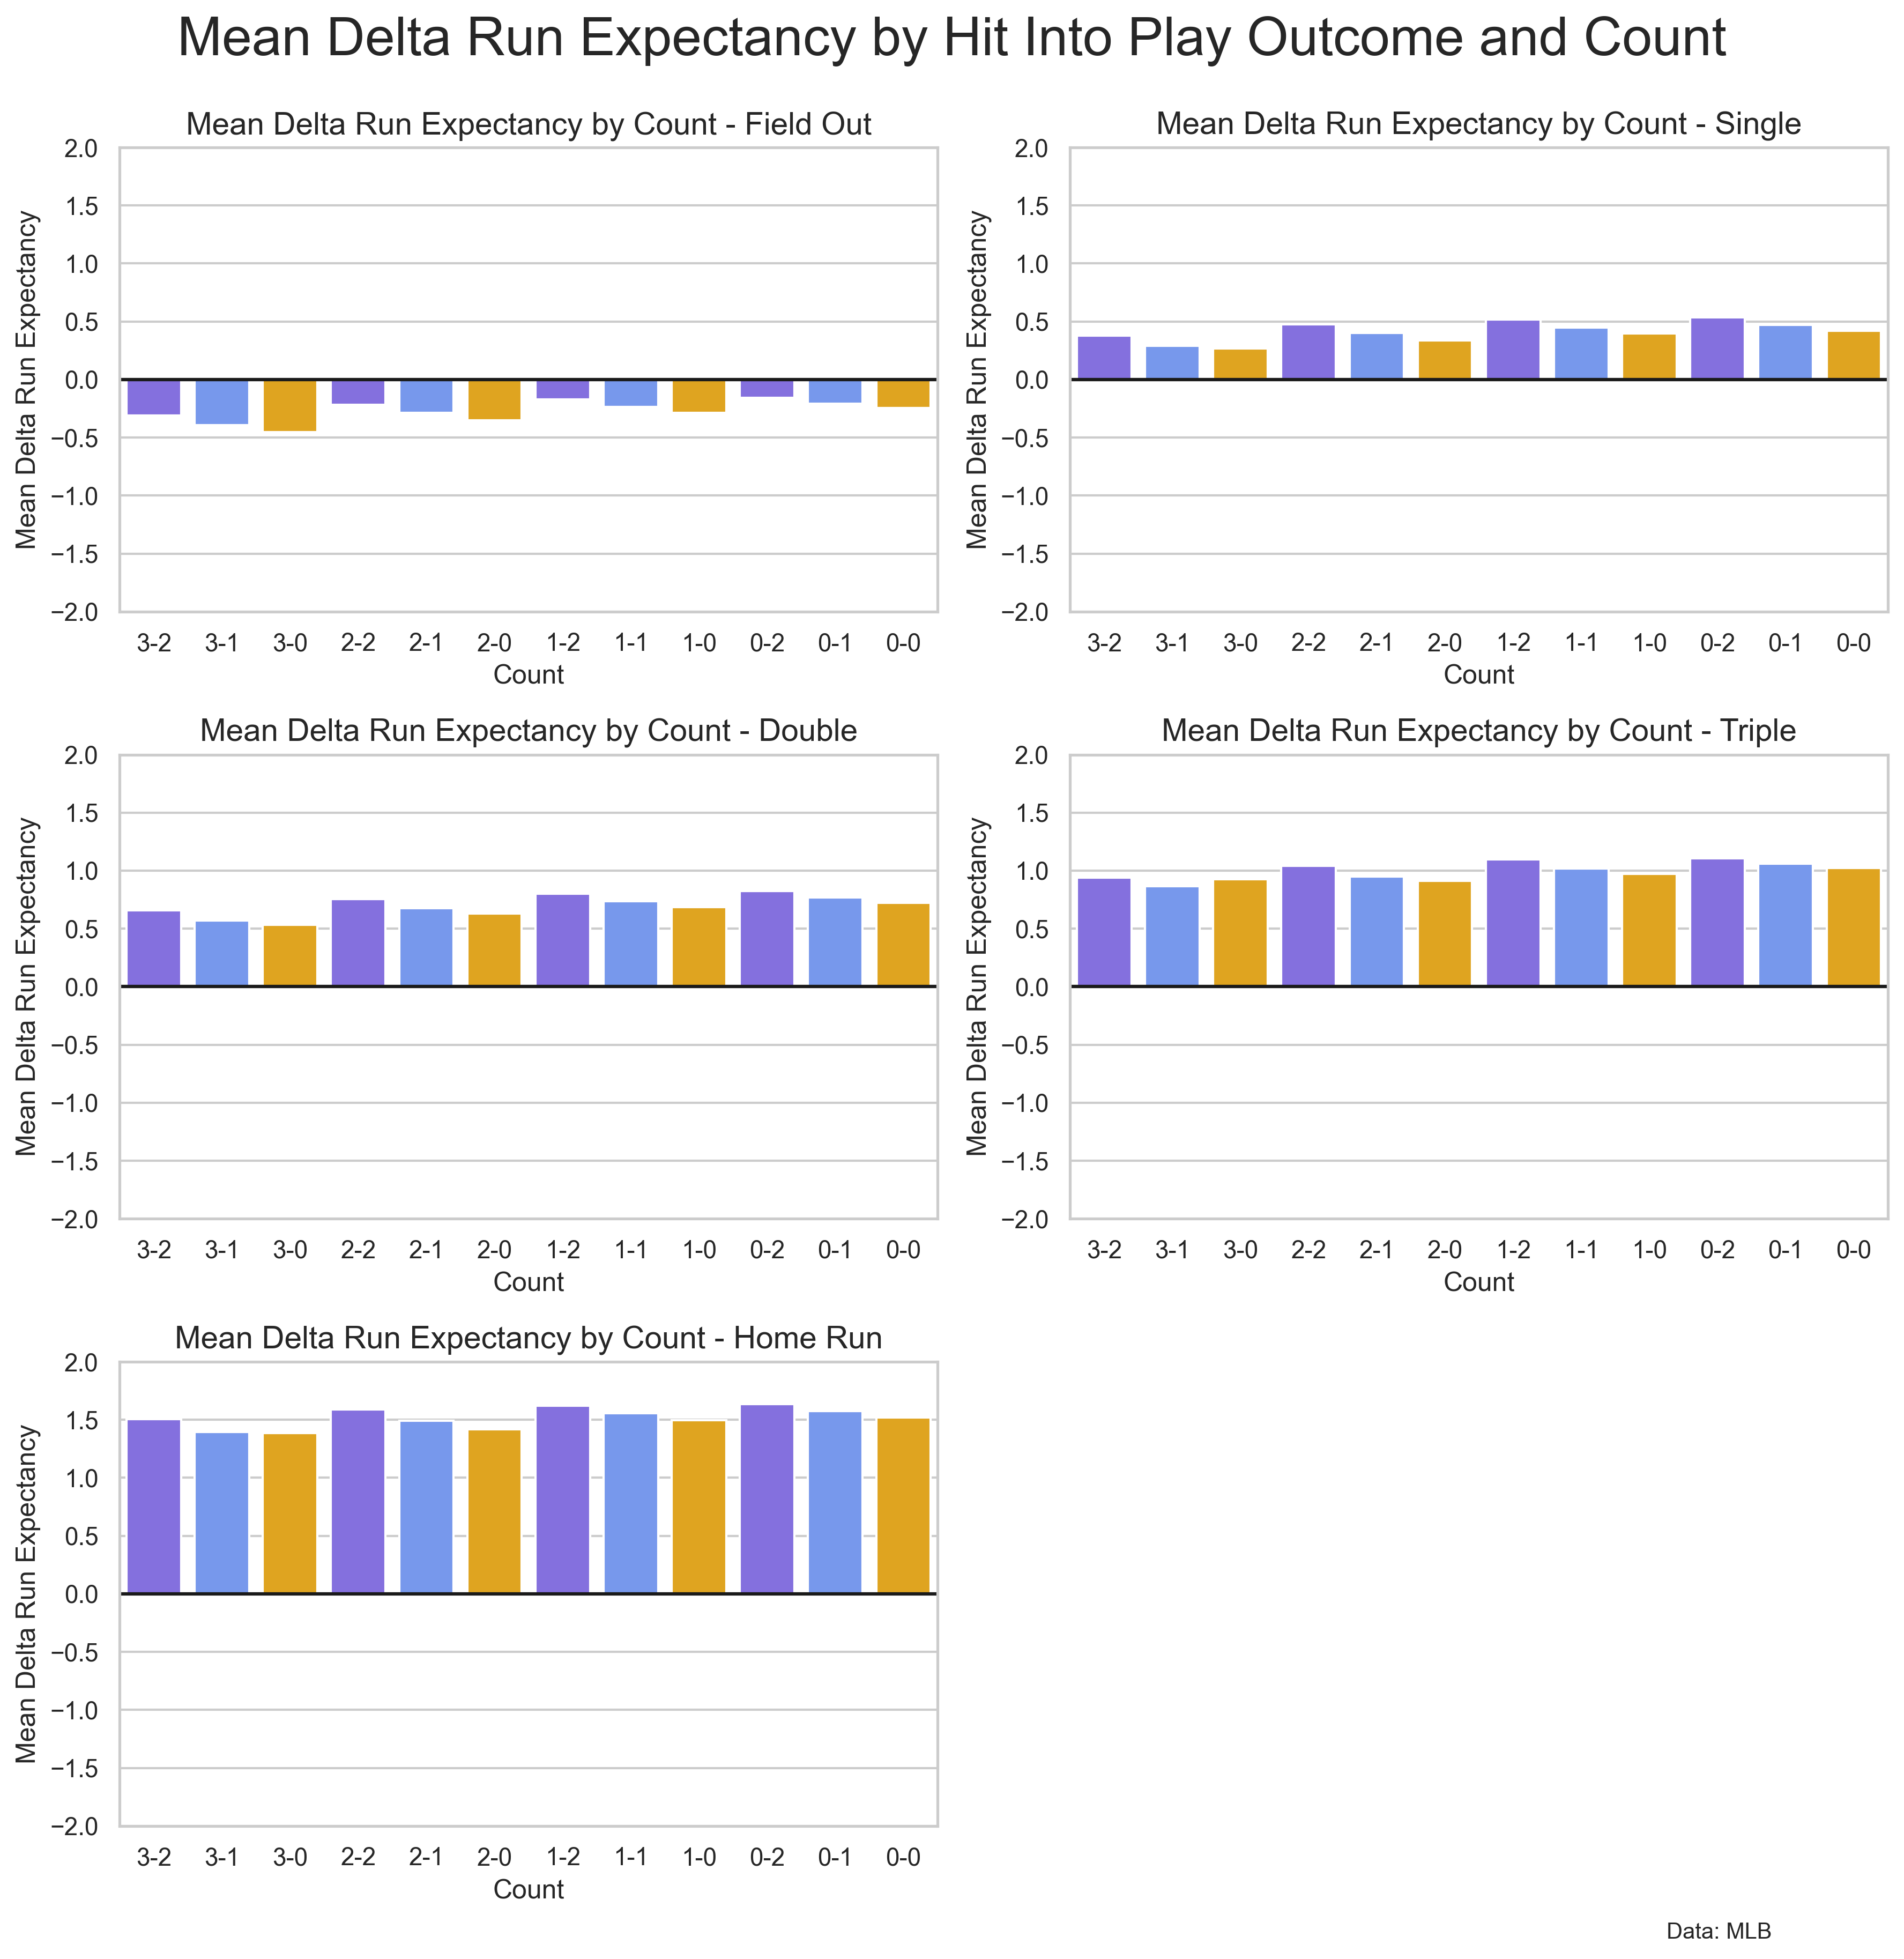

In [19]:
## Create Dataframe to plot Run Expectancies for Hits into Play
outcomes_df_hit = processed_train_data[processed_train_data.description == 'hit_into_play'].groupby(['ev_new', 'strikes', 'balls'])['delta_run_exp_mean'].mean().sort_values().reset_index()
outcomes_df_hit = outcomes_df_hit[outcomes_df_hit.ev_new.isin(processed_train_data[processed_train_data.description == 'hit_into_play'].ev_new.unique())]
outcomes_df_hit = outcomes_df_hit[(outcomes_df_hit.strikes <= 2) & (outcomes_df_hit.balls <= 3)]
outcomes_df_hit['count'] = outcomes_df_hit.balls.astype(str) + '-' + outcomes_df_hit.strikes.astype(str)
outcomes_df_hit = outcomes_df_hit.sort_values(['balls', 'strikes'], ascending = False)


outcome_titles_hit = {'single':'Single',
'field_out':'Field Out',
'double':'Double',
'home_run':'Home Run',
'triple':'Triple'}


sns.set_theme(style = "whitegrid")

fig, ax = plt.subplots(3, 2, figsize = (12, 12), dpi = 300)

axs = ax.flatten()
axs[5].axis('off')
for outx in range(0, len(outcomes_df_hit.ev_new.unique())):
    
    sns.barplot(data = outcomes_df_hit[outcomes_df_hit.ev_new == outcomes_df_hit.ev_new.unique()[outx]],
                y = 'delta_run_exp_mean', x = 'count', hue = 'count', palette = colour_palette[2::-1] * 4, ax = axs[outx])

    axs[outx].set_ylim(-2, 2)
    axs[outx].hlines(y = 0, xmin = -0.5, xmax = 11.5, color = 'k')
    axs[outx].set_xlim(-0.5, 11.5)

    axs[outx].set_xlabel('Count')
    axs[outx].set_ylabel('Mean Delta Run Expectancy')
    axs[outx].set_title(f'Mean Delta Run Expectancy by Count - {outcome_titles_hit[outcomes_df_hit.ev_new.unique()[outx]]}', fontsize = 14)

fig.suptitle(x = 0.5, y = 0.98, t = "Mean Delta Run Expectancy by Hit Into Play Outcome and Count", ha = 'center', va = 'center', fontsize = 24)
fig.text(0.925, 0.00, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)
fig.set_facecolor('white')
fig.tight_layout()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


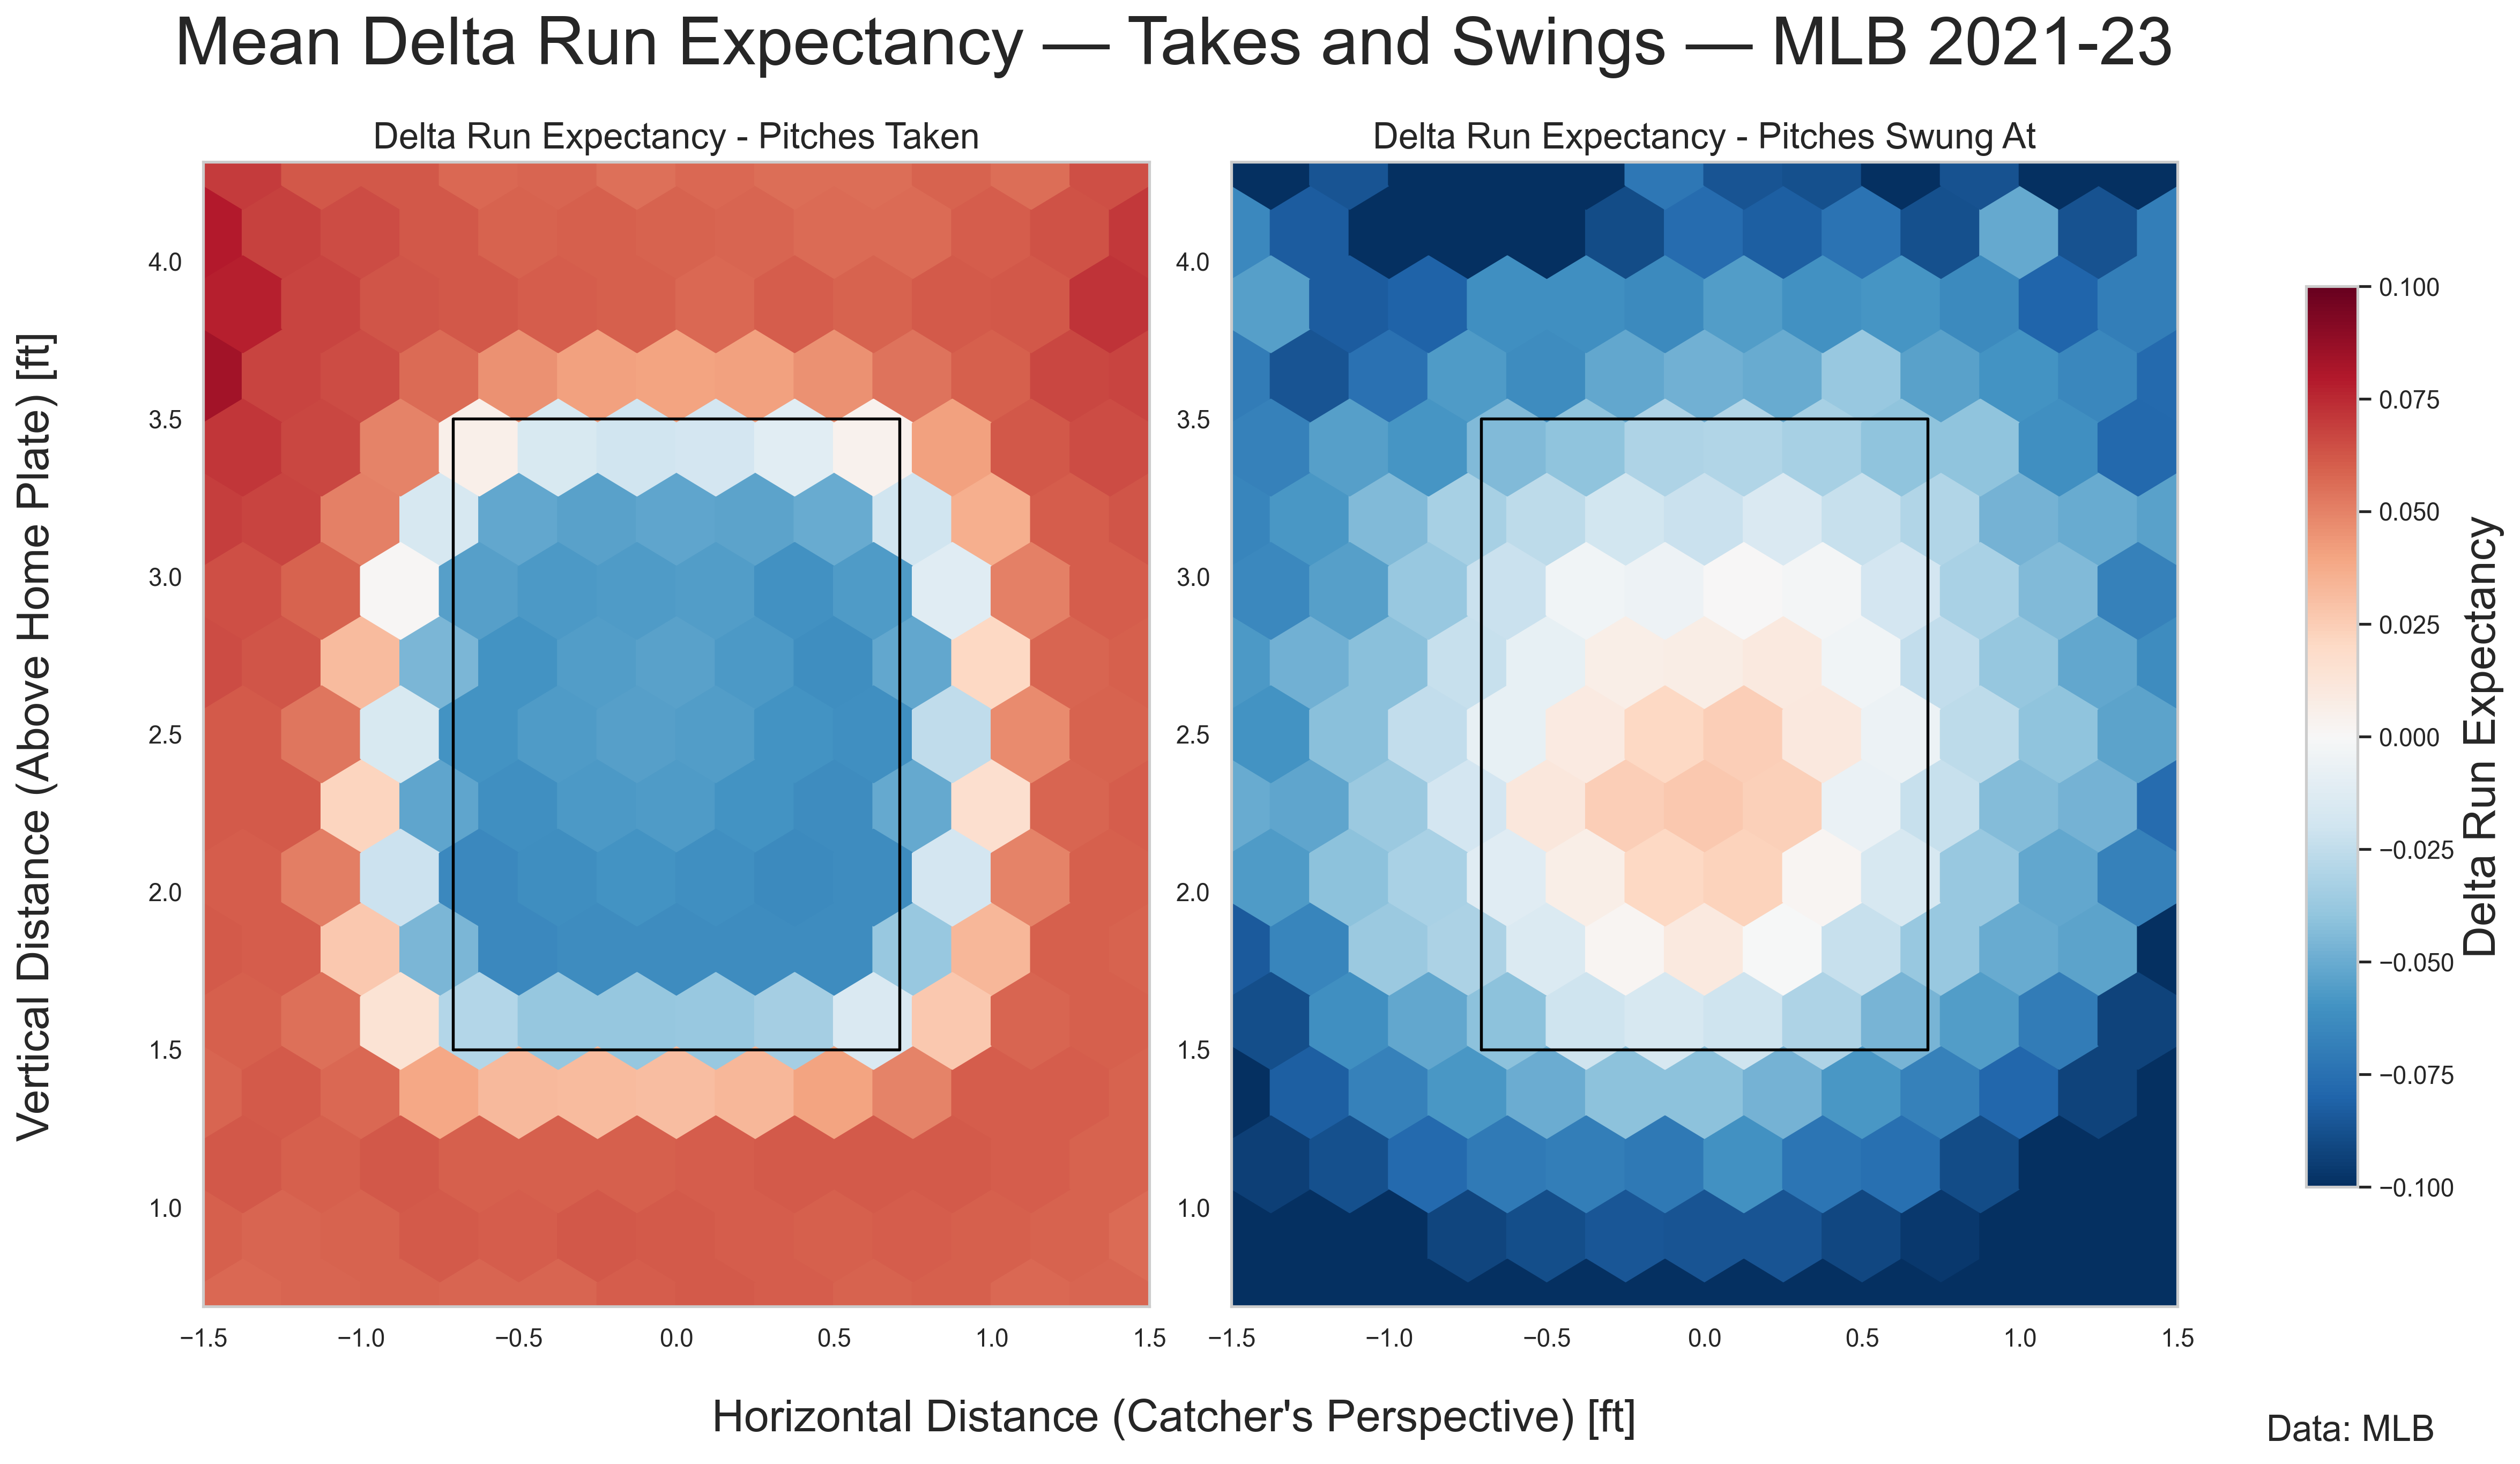

In [20]:
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1, 2, figsize = (16, 8), dpi = 300)
norm = colors.TwoSlopeNorm(vmin = vmin, vcenter = np.array([vmin,vmax]).mean(), vmax = vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap = 'RdBu_r', norm = norm)


ax[0].hexbin(x = processed_train_data[(processed_train_data.swing == 0)]['plate_x'],
            y = processed_train_data[(processed_train_data.swing == 0)]['plate_z'],
            C = processed_train_data[(processed_train_data.swing == 0)]['delta_run_exp_mean'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)


ax[1].hexbin(x = processed_train_data[(processed_train_data.swing == 1)]['plate_x'],
            y = processed_train_data[(processed_train_data.swing == 1)]['plate_z'],
            C = processed_train_data[(processed_train_data.swing == 1)]['delta_run_exp_mean'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5, 1.5)
ax[1].set_xlim(-1.5, 1.5)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)

ax[0].set_ylim(1, 4)
ax[1].set_ylim(1, 4)

ax[0].set_title('Delta Run Expectancy - Pitches Taken', fontsize = 16)
ax[1].set_title('Delta Run Expectancy - Pitches Swung At', fontsize = 16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax = cbar_ax, aspect = 30, shrink = 0.7)
cbar_big.set_label('Delta Run Expectancy', fontsize = 20)

fig.subplots_adjust(right = 0.8)

fig.suptitle(x = 0.41, y = 1.06, t = f"Mean Delta Run Expectancy — Takes and Swings — MLB 2021-23", fontsize = 30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha = 'center', fontsize = 20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va = 'center', rotation = 'vertical', fontsize = 20)

fig.text(0.9, -0.04, "Data: MLB",ha = 'right', va = 'center', fontsize = 16)
fig.set_facecolor('white')

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


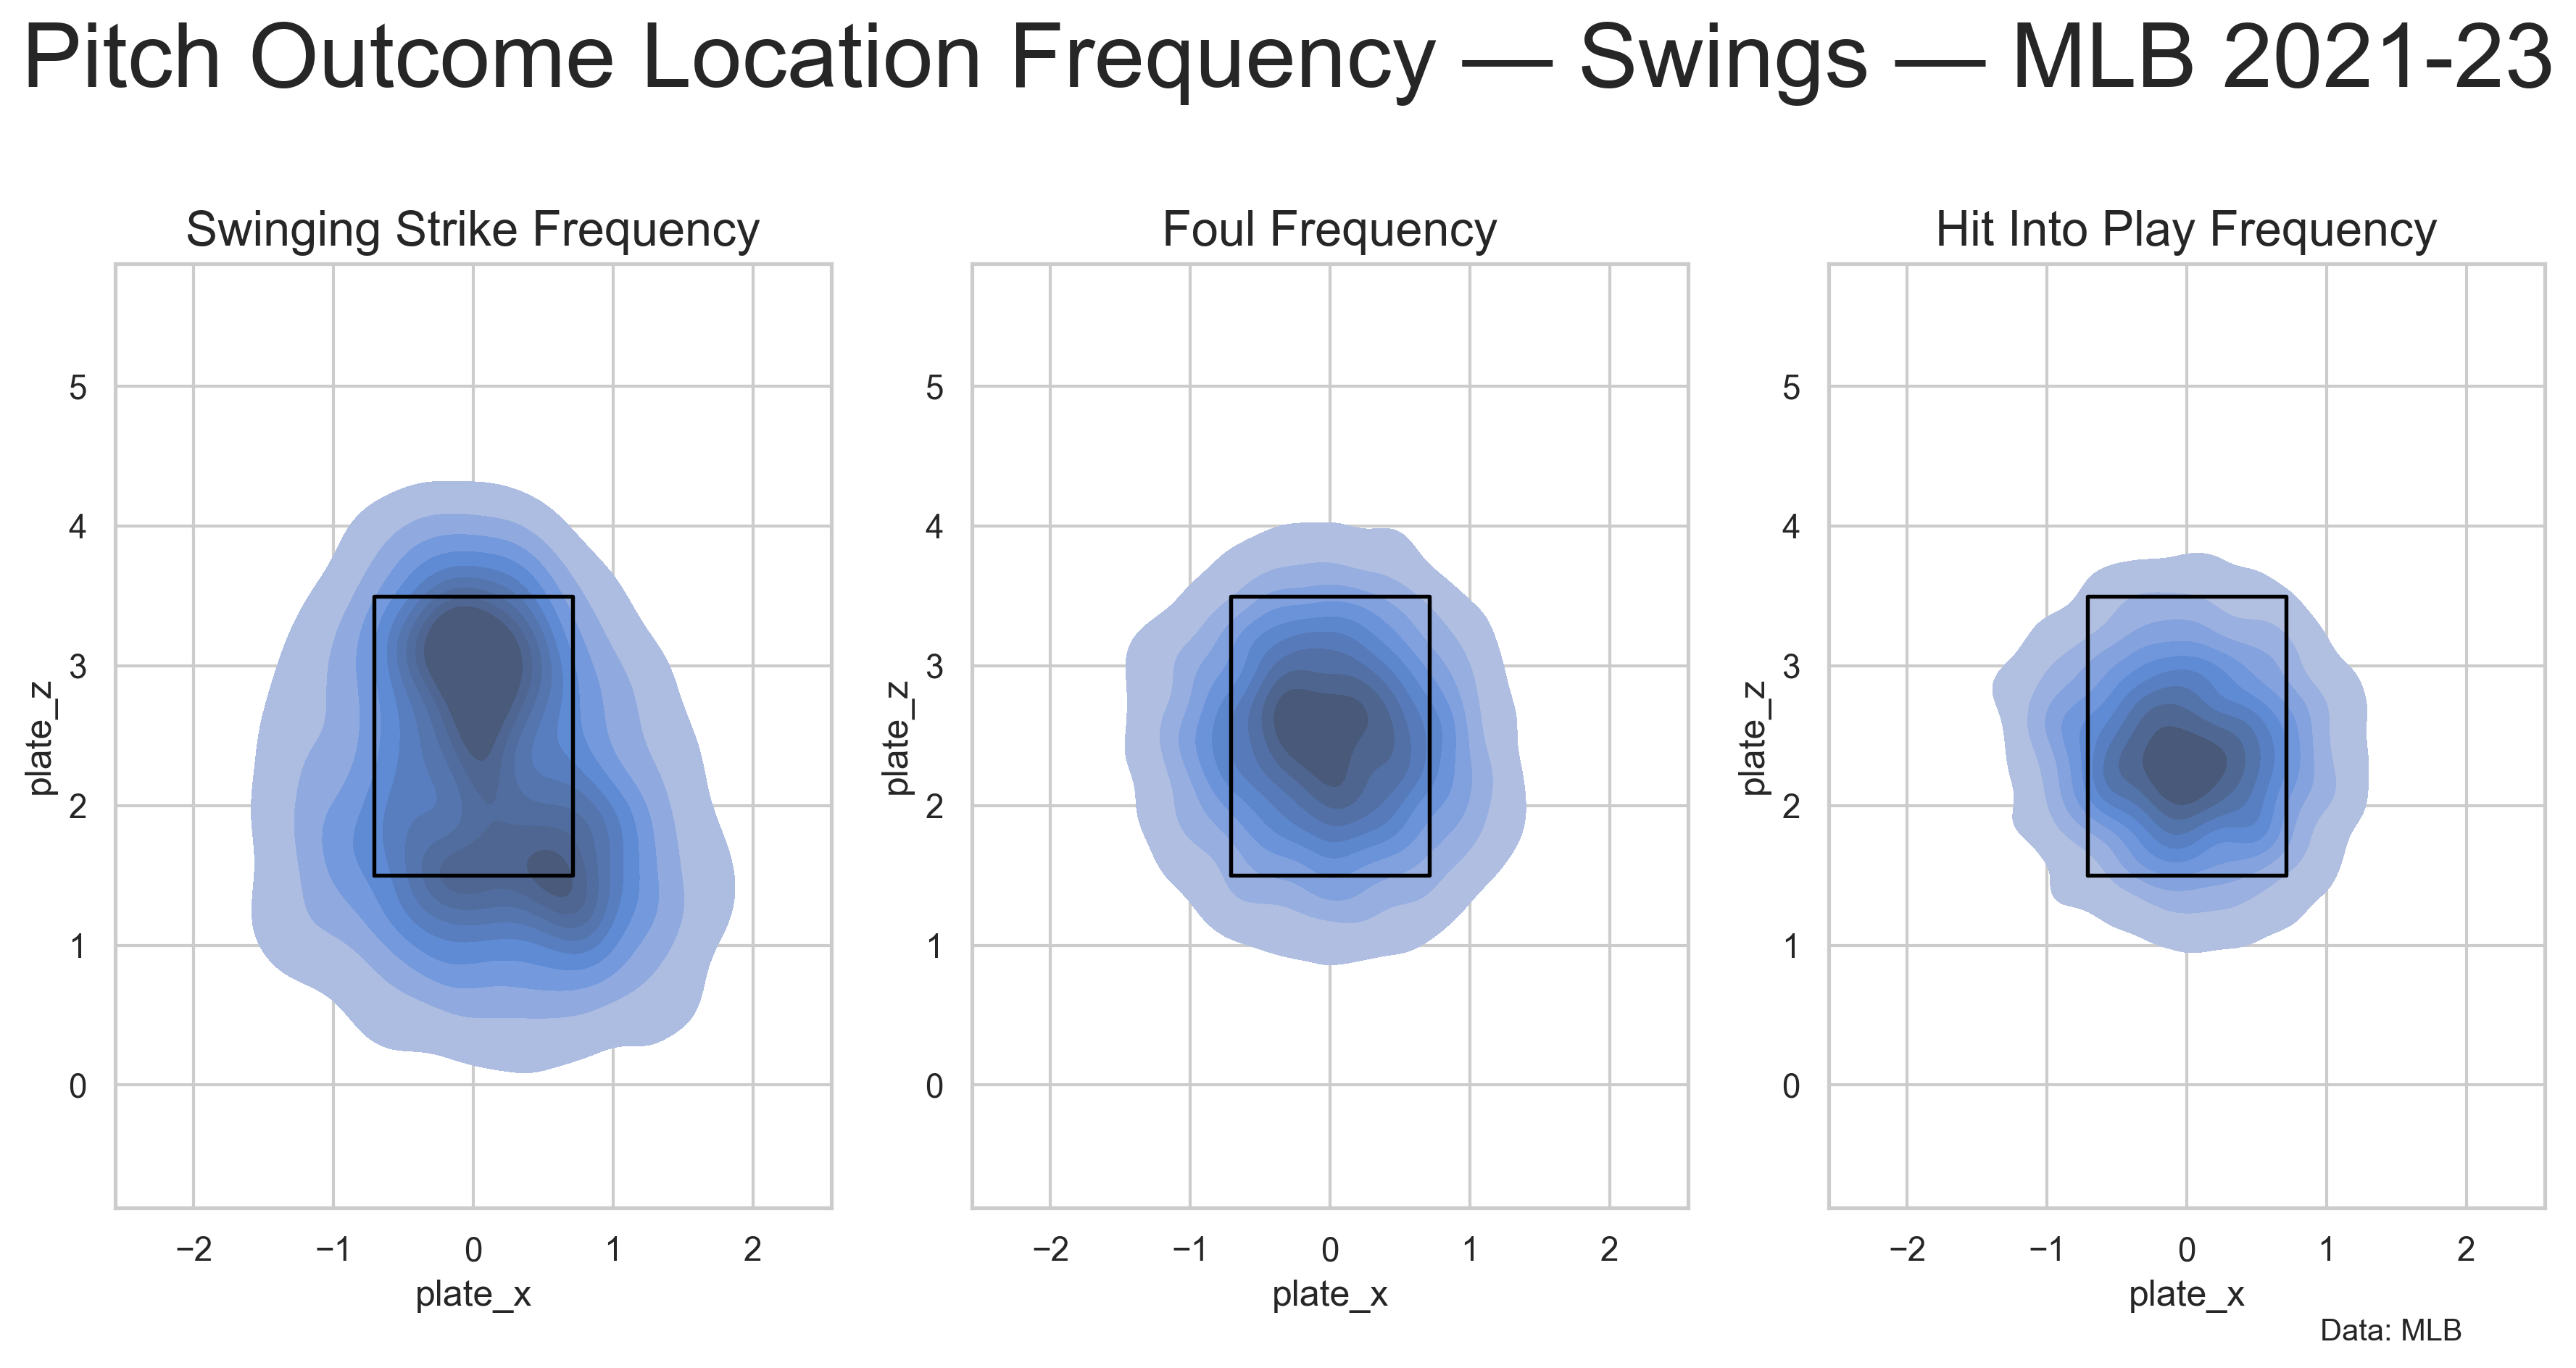

In [21]:
fig, ax = plt.subplots(1, 3, figsize = (12, 6), dpi = 300)

sns.kdeplot(data = processed_train_data[(processed_train_data.des_new == 'swinging_strike') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[0]
)

sns.kdeplot(data = processed_train_data[(processed_train_data.des_new == 'foul') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[1]
)

sns.kdeplot(data = processed_train_data[(processed_train_data.description == 'hit_into_play') & (processed_train_data.swing == 1)].sample(5000),
    x = 'plate_x',
    y = 'plate_z',
    fill = True,
    ax = ax[2]
)

ax[0].axis('equal')
ax[1].axis('equal')
ax[2].axis('equal')
ax[0].set_xlim(-2, 2)
ax[1].set_xlim(-2, 2)
ax[2].set_xlim(-2, 2)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)
draw_line(ax[2], catcher_p = False)


ax[0].set_ylim(0.5, 4.5)
ax[1].set_ylim(0.5, 4.5)
ax[2].set_ylim(0.5, 4.5)

ax[0].set_title('Swinging Strike Frequency', fontsize = 16)
ax[1].set_title('Foul Frequency', fontsize = 16)
ax[2].set_title('Hit Into Play Frequency', fontsize = 16)

fig.suptitle(x = 0.5, y = 1.02, t = f"Pitch Outcome Location Frequency — Swings — MLB 2021-23", fontsize = 30)

fig.text(0.95, 0.015, "Data: MLB",ha = 'right', va = 'center', fontsize = 10)
fig.tight_layout()

In [22]:
def plot_nitro_zone(df, batter_id, year, strike_zone_dims = (3.5, 1.5, -0.708, 0.708)):
    player_df = df[(df['batter'] == batter_id) & (df['description'] == 'hit_into_play')].dropna(subset = ['plate_x', 'plate_z'])
    nitro_df = player_df[player_df['in_nitro']]
    hull = nitro_df.iloc[0, -2]
    df_name = playerid_reverse_lookup([batter_id])
    player_name = df_name['name_first'].values[0] + ' ' + df_name['name_last'].values[0]
    player_name = player_name.title()
    
    fig, ax = plt.subplots(figsize = (6, 6))
    
    # Plot all pitches
    ax.scatter(player_df['plate_x'], player_df['plate_z'], alpha = 0.2, label = 'All Pitches', color = 'skyblue')
    
    # Plot nitro zone pitches
    ax.scatter(nitro_df['plate_x'], nitro_df['plate_z'], alpha = 0.9, color = 'red', label = 'Nitro Zone Pitches')
    
    # Convex Hull around nitro pitches
    boundary_labeled = False  # Flag to track if we've already added the label
    for simplex in hull.simplices:
        if not boundary_labeled:
            ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r--', lw = 2, label = 'Nitro Zone Boundary')
            boundary_labeled = True
        else:
            ax.plot(hull.points[simplex, 0], hull.points[simplex, 1], 'r--', lw = 2)
    
    # Strike zone
    top, bottom, left, right = strike_zone_dims
    strike_x = [left, right, right, left, left]
    strike_z = [bottom, bottom, top, top, bottom]
    ax.plot(strike_x, strike_z, 'k-', lw = 2, label = 'Strike Zone')
    
    # Labels and aesthetics
    ax.set_title(f"{player_name}'s Nitro Zone in {year}")
    ax.set_xlabel("Plate X (Horizontal Location)")
    ax.set_ylabel("Plate Z (Vertical Location)")
    ax.set_xlim(-2, 2)
    ax.set_ylim(0.5, 5)
    ax.legend(loc = 'upper right')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


Gathering player lookup table. This may take a moment.


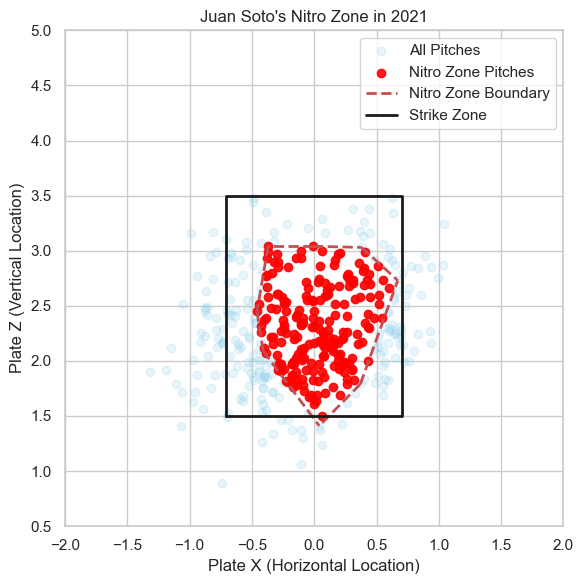

In [23]:
plot_nitro_zone(processed_data_2021, 665742, 2021)

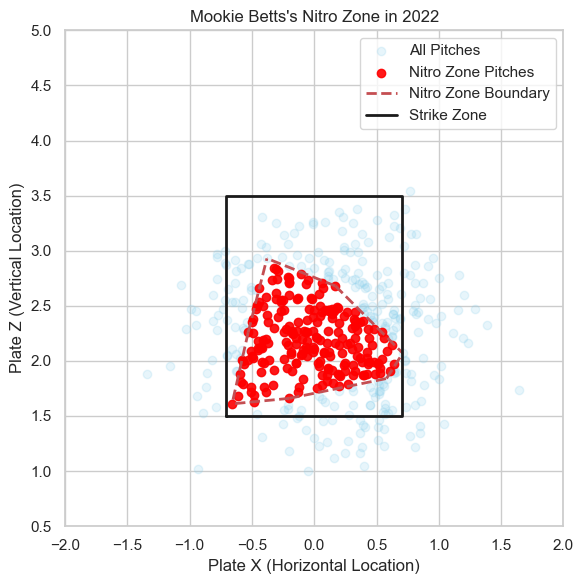

In [24]:
plot_nitro_zone(processed_data_2022, 605141, 2022)

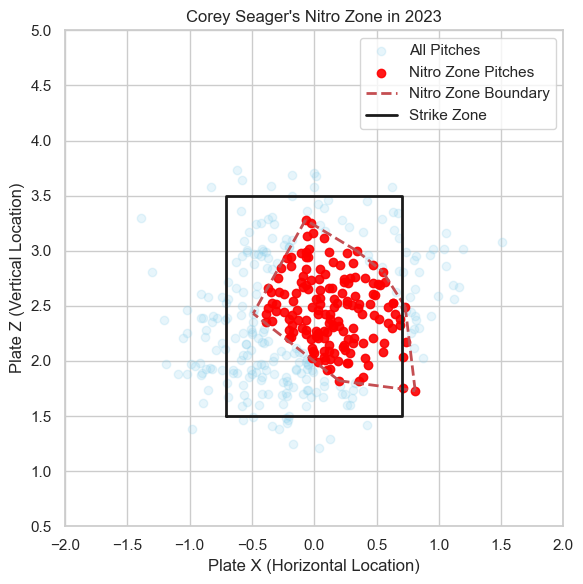

In [25]:
plot_nitro_zone(processed_data_2023, 608369, 2023)

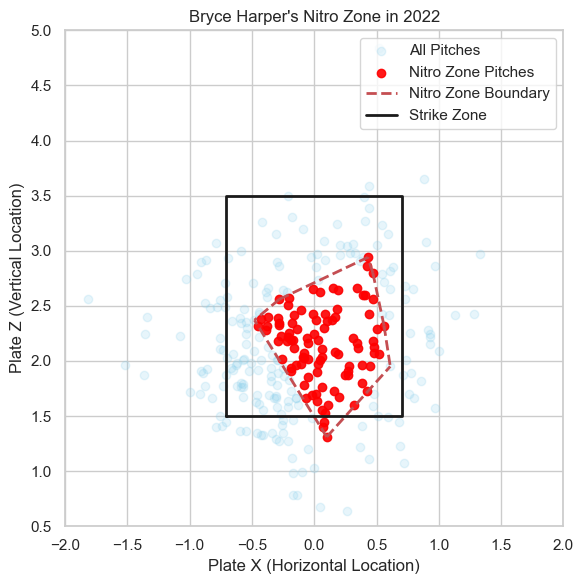

In [26]:
plot_nitro_zone(processed_data_2022, 547180, 2022)

### Modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [17]:
def evaluate(model, dtrain, dtest):
    train_pred = model.predict(dtrain)
    train_error = root_mean_squared_error(dtrain.get_label(), train_pred)
    test_pred = model.predict(dtest)
    test_error = root_mean_squared_error(dtest.get_label(), test_pred)

    print(f'Training RMSE: {train_error}\nTesting RMSE: {test_error}')

In [18]:
def sklearn_evaluate(model, x_train, y_train, x_test, y_test):
    train_pred = model.predict(x_train)
    train_error = root_mean_squared_error(y_train, train_pred)
    test_pred = model.predict(x_test)
    test_error = root_mean_squared_error(y_test, test_pred)

    print(f'Training RMSE: {train_error}\nTesting RMSE: {test_error}')

##### Prepare Data For Models

In [19]:
features = ['plate_x', 'plate_z', 'in_nitro', 'count']
target = 'delta_run_exp_mean'

In [20]:
data_no_swing = processed_train_data.loc[processed_train_data['swing'] != 1, features + [target]]
data_swing = processed_train_data.loc[processed_train_data['swing'] == 1, features + [target]]
data_no_swing = data_no_swing.dropna().reset_index(drop = True)
data_swing = data_swing.dropna().reset_index(drop = True)

x_no_swing = data_no_swing.loc[:, features]
y_no_swing = data_no_swing.loc[:, target]
x_swing = data_swing.loc[:, features]
y_swing = data_swing.loc[:, target]

In [21]:
x_train_no_swing, x_test_no_swing, y_train_no_swing, y_test_no_swing = train_test_split(x_no_swing, y_no_swing, test_size = 0.2, random_state = seed)
x_train_swing, x_test_swing, y_train_swing, y_test_swing = train_test_split(x_swing, y_swing, test_size = 0.2, random_state = seed)

In [22]:
print(x_train_no_swing.shape)
print(x_test_no_swing.shape)
print(x_train_swing.shape)
print(x_test_swing.shape)

(849749, 4)
(212438, 4)
(772168, 4)
(193043, 4)


##### XGBoost

In [23]:
d_train_no_swing = xgb.DMatrix(x_train_no_swing, label = y_train_no_swing, enable_categorical = True)
d_test_no_swing = xgb.DMatrix(x_test_no_swing, label = y_test_no_swing, enable_categorical = True)
d_train_swing = xgb.DMatrix(x_train_swing, label = y_train_swing, enable_categorical = True)
d_test_swing = xgb.DMatrix(x_test_swing, label = y_test_swing, enable_categorical = True)

In [24]:
params = {'objective': 'reg:squarederror', 'max_depth': 8, 'learning_rate': 0.03, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [25]:
xgb_model_no_swing = xgb.train(params, d_train_no_swing, num_rounds)

In [26]:
evaluate(xgb_model_no_swing, d_train_no_swing, d_test_no_swing) 

Training RMSE: 0.0432017557322979
Testing RMSE: 0.044595882296562195


In [27]:
params = {'objective': 'reg:squarederror', 'max_depth': 9, 'learning_rate': 0.01, 'eval_metric': 'rmse', 'random_state': seed, 'tree_method': 'hist'}
num_rounds = 200

In [28]:
xgb_model_swing = xgb.train(params, d_train_swing, num_rounds)

In [58]:
evaluate(xgb_model_swing, d_train_swing, d_test_swing)

Training RMSE: 0.29770028591156006
Testing RMSE: 0.29807937145233154


##### LightGBM

In [29]:
d_train_no_swing = lgb.Dataset(x_train_no_swing, label = y_train_no_swing)
d_test_no_swing = lgb.Dataset(x_test_no_swing, label = y_test_no_swing)
d_train_swing = lgb.Dataset(x_train_swing, label = y_train_swing)
d_test_swing = lgb.Dataset(x_test_swing, label = y_test_swing)

In [39]:
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [40]:
lgb_model_no_swing = lgb.train(params, d_train_no_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 849749, number of used features: 4
[LightGBM] [Info] Start training from score 0.022310


In [41]:
sklearn_evaluate(lgb_model_no_swing, x_train_no_swing, y_train_no_swing, x_test_no_swing, y_test_no_swing)

Training RMSE: 0.04372641619530345
Testing RMSE: 0.0445539787490001


In [33]:
params = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [34]:
lgb_model_swing = lgb.train(params, d_train_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 772168, number of used features: 4
[LightGBM] [Info] Start training from score -0.022336


In [35]:
sklearn_evaluate(lgb_model_swing, x_train_swing, y_train_swing, x_test_swing, y_test_swing)

Training RMSE: 0.29805595194455864
Testing RMSE: 0.29627085430359795


##### The performance of LightGBM is slightly better. Therefore, I choosed LightGBM as my model and trained the model using all the data from 2021 to 2023.

In [42]:
d_no_swing = lgb.Dataset(x_no_swing, label = y_no_swing)
d_swing = lgb.Dataset(x_swing, label = y_swing)

In [43]:
params_no_swing = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [44]:
lgb_model_no_swing = lgb.train(params_no_swing, d_no_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 1062187, number of used features: 4
[LightGBM] [Info] Start training from score 0.022310


In [46]:
preds = lgb_model_no_swing.predict(x_no_swing)
print(root_mean_squared_error(y_no_swing, preds))

0.04383112199455115


In [47]:
params_swing = {'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.02, 'random_state': seed}
num_rounds = 800

In [48]:
lgb_model_swing = lgb.train(params_swing, d_swing, num_rounds)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 524
[LightGBM] [Info] Number of data points in the train set: 965211, number of used features: 4
[LightGBM] [Info] Start training from score -0.022465


In [49]:
preds = lgb_model_swing.predict(x_swing)
print(root_mean_squared_error(y_swing, preds))

0.2976845393718202


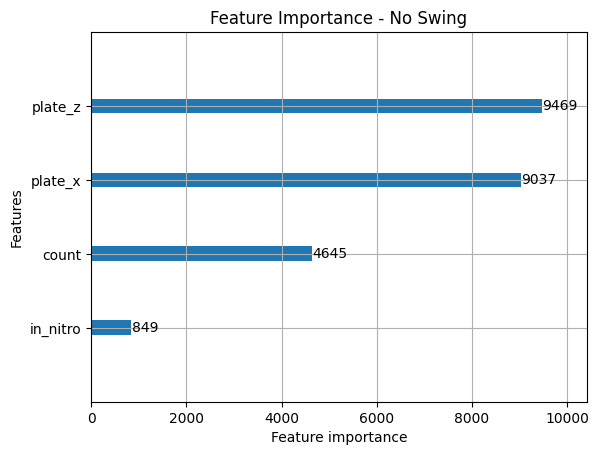

In [50]:
lgb.plot_importance(lgb_model_no_swing)
plt.title('Feature Importance - No Swing')
plt.show()

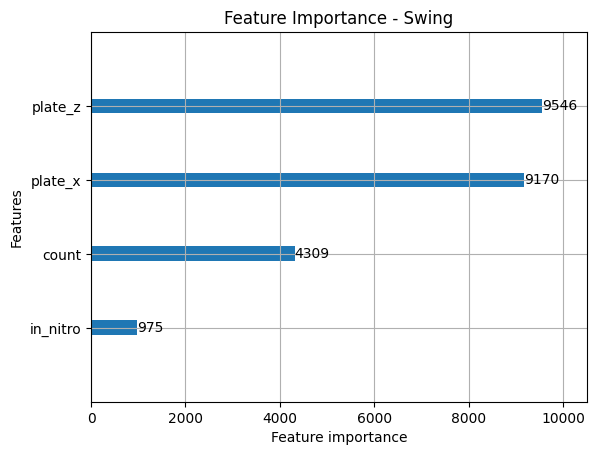

In [51]:
lgb.plot_importance(lgb_model_swing)
plt.title('Feature Importance - Swing')
plt.show()

### Analysis

In [52]:
from scipy.stats import zscore
from sklearn.metrics import r2_score
import math

In [53]:
def add_batter_name(df):
    batter_data = playerid_reverse_lookup(df['batter'].values)
    batter_data['batter_name'] = batter_data['name_last'] + ', ' + batter_data['name_first']
    batter_data = batter_data.loc[:, ['key_mlbam', 'batter_name']]
    df = df.merge(batter_data, left_on = 'batter', right_on = 'key_mlbam')

    return df

In [54]:
def calculate_player_decision_value(df, min_pitches = None):
    df_grouped = df.groupby(['batter', 'batter_name']).agg(pitches = ('release_speed', 'count'), y_pred = ('y_pred', 'mean'), delta_run_exp = ('delta_run_exp', 'mean'))
    df_grouped = df_grouped.reset_index()

    df_grouped.loc[:, 'decision_value'] = zscore(df_grouped['y_pred'].values)
    df_grouped.loc[:, 'decision_value'] = 100 + df_grouped['decision_value'] * 10

    if min_pitches:
        df_grouped = df_grouped.loc[df_grouped['pitches'] >= min_pitches, :]

    return df_grouped

In [55]:
def evaluate_stabilization_by_player(df, player_col, value_col, 
                                     min_size = 10, max_size = 500, step = 10, 
                                     players_per_group = 100, threshold = 0.7):
    results = []

    for sample_size in tqdm(range(min_size, max_size + 1, step)):

        sampled_players = np.random.choice(df[player_col].unique(), players_per_group, replace = False)
        pitch_matrix = []

        for player in sampled_players:
            player_vals = df[df[player_col] == player][value_col]
            pitch_sample = player_vals.sample(sample_size, replace = True).values
            pitch_matrix.append(pitch_sample)

        if len(pitch_matrix) == players_per_group:
            df_alpha = pd.DataFrame(pitch_matrix)
            alpha, _ = pg.cronbach_alpha(data = df_alpha)  # transpose so raters are rows

        results.append({'sample_size': sample_size, 'cronbach_alpha': alpha})
        if alpha >= threshold:
            break

    return pd.DataFrame(results)

In [56]:
processed_train_data = add_batter_name(processed_train_data)
processed_test_data = add_batter_name(processed_test_data)

Gathering player lookup table. This may take a moment.


In [57]:
processed_train_data.loc[processed_train_data['swing'] == 0, 'y_pred'] = lgb_model_no_swing.predict(processed_train_data.loc[processed_train_data['swing'] == 0, features])
processed_train_data.loc[processed_train_data['swing'] == 1, 'y_pred'] = lgb_model_swing.predict(processed_train_data.loc[processed_train_data['swing'] == 1, features])

In [59]:
processed_test_data.loc[processed_test_data['swing'] == 0, 'y_pred'] = lgb_model_no_swing.predict(processed_test_data.loc[processed_test_data['swing'] == 0, features])
processed_test_data.loc[processed_test_data['swing'] == 1, 'y_pred'] = lgb_model_swing.predict(processed_test_data.loc[processed_test_data['swing'] == 1, features])

In [ ]:
min_size = 500

processed_data_2023 = processed_train_data.loc[processed_train_data['game_date'] > '2023-01-01', :]
processed_data_2023_grouped = processed_data_2023.groupby(['batter']).agg(pitches = ('release_speed', 'count'))
processed_data_2023_grouped = processed_data_2023_grouped.reset_index()
qulified_batters = processed_data_2023_grouped.loc[processed_data_2023_grouped['pitches'] >= min_size, 'batter']

In [61]:
results = evaluate_stabilization_by_player(processed_data_2023.loc[processed_data_2023['batter'].isin(qulified_batters), :], 'batter', 'y_pred')
print(results)

  0%|          | 0/50 [00:00<?, ?it/s]

    sample_size  cronbach_alpha
0            10       -0.079356
1            20       -0.102804
2            30        0.310677
3            40        0.132726
4            50        0.094733
5            60        0.237906
6            70        0.257314
7            80        0.292368
8            90        0.074075
9           100        0.215936
10          110        0.376033
11          120        0.413397
12          130        0.261218
13          140        0.163114
14          150        0.355296
15          160        0.377152
16          170        0.505069
17          180        0.324479
18          190        0.552200
19          200        0.434713
20          210        0.523481
21          220        0.535092
22          230        0.354741
23          240        0.408779
24          250        0.468003
25          260        0.514721
26          270        0.488366
27          280        0.567653
28          290        0.529999
29          300        0.431852
30      

##### With 450 pitches, Cronbach's Alpha can reach over 0.7. This means that my swing decision value is sufficiently sticky.

In [62]:
processed_data_2022 = processed_train_data.loc[(processed_train_data['game_date'] > '2022-01-01') & (processed_train_data['game_date'] < '2022-12-31'), :]

In [63]:
processed_data_2023_grouped = calculate_player_decision_value(processed_data_2023, min_pitches = 500)
processed_data_2022_grouped = calculate_player_decision_value(processed_data_2022, min_pitches = 500)

In [64]:
processed_data_2022_2023_grouped = pd.merge(processed_data_2022_grouped, processed_data_2023_grouped, how = 'inner', on = 'batter', suffixes =  ('_2022', '_2023'))

In [65]:
r2_result = np.power(np.corrcoef(processed_data_2022_2023_grouped['decision_value_2022'].values, processed_data_2022_2023_grouped['decision_value_2023'].values)[0][1], 2)

Text(0.05, 0.9, '$R^2$ = 0.34')

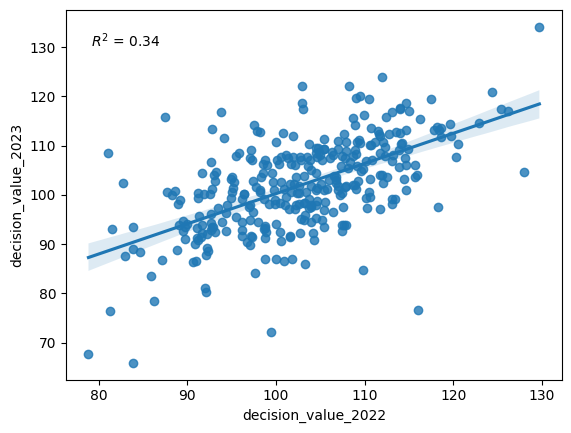

In [66]:
ax = sns.regplot(x = 'decision_value_2022', y = 'decision_value_2023', data = processed_data_2022_2023_grouped)
ax.text(0.05, 0.9, f'$R^2$ = {r2_result:.2f}', transform = ax.transAxes)

##### The decision value year to year in version 2 is less sticky than in version 1. However, it still shows some degree of stickiness.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


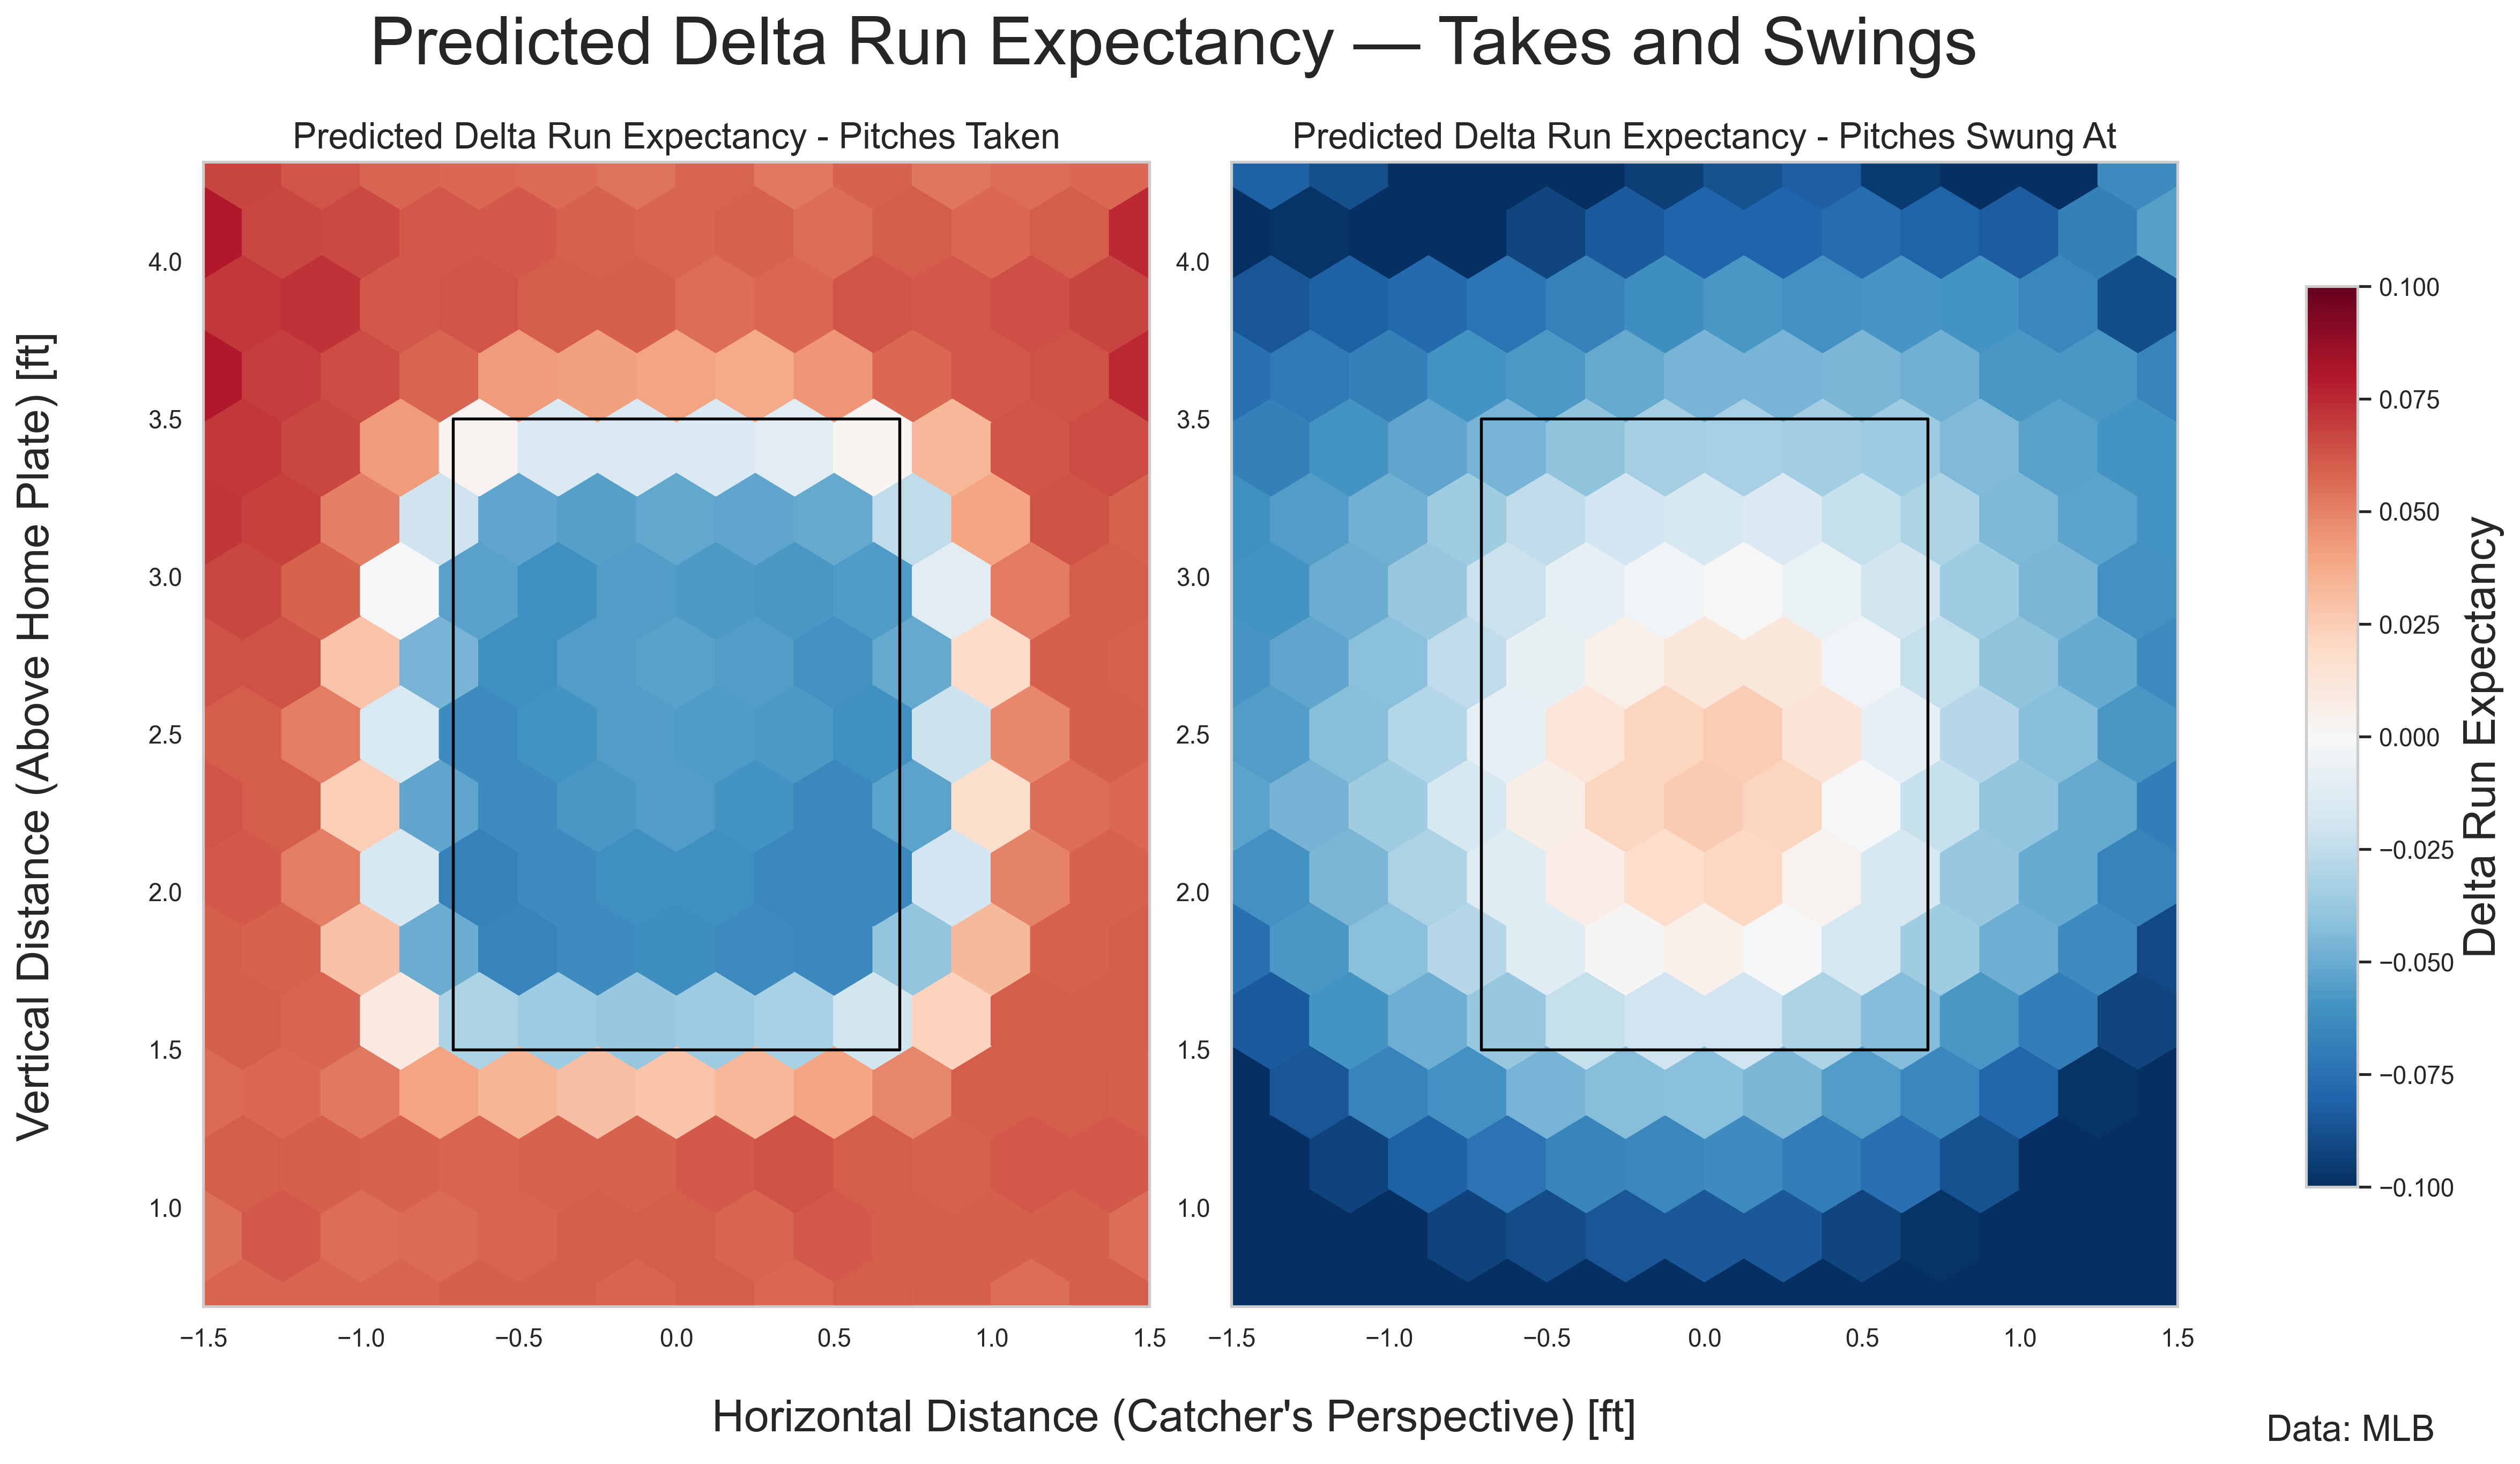

In [67]:
x_min = -2.5
x_max = 2.5
y_min = 0
y_max = 5
extent = [x_min, x_max, y_min, y_max]

# define your scale, with white at zero
vmin = -0.1
vmax = 0.1

#for p_th in range(0,2):
sns.set_theme(style = "whitegrid")
fig, ax = plt.subplots(1, 2, figsize = (16, 8), dpi = 300)
norm = colors.TwoSlopeNorm(vmin = vmin, vcenter = np.array([vmin,vmax]).mean(), vmax = vmax)
#norm = plt.Normalize(vmin,vmax)
sm = plt.cm.ScalarMappable(cmap = 'RdBu_r', norm = norm)


ax[0].hexbin(x = processed_test_data[(processed_test_data.swing == 0)]['plate_x'],
            y = processed_test_data[(processed_test_data.swing == 0)]['plate_z'],
            C = processed_test_data[(processed_test_data.swing == 0)]['y_pred'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)


ax[1].hexbin(x = processed_test_data[(processed_test_data.swing == 1)]['plate_x'],
            y = processed_test_data[(processed_test_data.swing == 1)]['plate_z'],
            C = processed_test_data[(processed_test_data.swing == 1)]['y_pred'],
            cmap = 'RdBu_r', norm = norm, extent = extent, gridsize = 20)
ax[0].axis('equal')
ax[1].axis('equal')
ax[0].set_xlim(-1.5, 1.5)
ax[1].set_xlim(-1.5, 1.5)

draw_line(ax[0], catcher_p = False)
draw_line(ax[1], catcher_p = False)

ax[0].set_ylim(1, 4)
ax[1].set_ylim(1, 4)

ax[0].set_title('Predicted Delta Run Expectancy - Pitches Taken', fontsize = 16)
ax[1].set_title('Predicted Delta Run Expectancy - Pitches Swung At', fontsize = 16)
fig.tight_layout()



cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar_big = fig.colorbar(sm, cax = cbar_ax, aspect = 30, shrink = 0.7)
cbar_big.set_label('Delta Run Expectancy', fontsize = 20)

fig.subplots_adjust(right = 0.8)

fig.suptitle(x = 0.41, y = 1.06, t = f"Predicted Delta Run Expectancy — Takes and Swings", fontsize = 30)
fig.text(0.41, -0.04, "Horizontal Distance (Catcher's Perspective) [ft]", ha = 'center', fontsize = 20)
fig.text(-0.04, 0.5, "Vertical Distance (Above Home Plate) [ft]", va = 'center', rotation = 'vertical', fontsize = 20)

fig.text(0.9, -0.04, "Data: MLB",ha = 'right', va = 'center', fontsize = 16)
fig.set_facecolor('white')

In [68]:
data_2024_grouped = calculate_player_decision_value(processed_test_data, min_pitches = 500)

In [69]:
data_2024_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

batter       batter_name  pitches    y_pred  delta_run_exp  \
215  663656      tucker, kyle     1349  0.012291       0.024215   
244  665742        soto, juan     2957  0.012267       0.024599   
28   543760    semien, marcus     2626  0.008903       0.000078   
317  670032      lopez, nicky     1628  0.007624      -0.005260   
231  664238      moore, dylan     1804  0.007277      -0.001091   
29   543807  springer, george     2299  0.007262      -0.001052   
57   592450      judge, aaron     2881  0.007221       0.033666   
169  650402   torres, gleyber     2813  0.007106       0.000022   
164  647304      naylor, josh     2283  0.007050       0.005343   
441  694384   schanuel, nolan     2356  0.006708       0.001504   

     decision_value  
215      130.535322  
244      130.478777  
28       122.510569  
317      119.479607  
231      118.658144  
29       118.624019  
57       118.526745  
169      118.254598  
164      118.121287  
441      117.309653

In [70]:
data_2024_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

batter             batter_name  pitches    y_pred  delta_run_exp  \
373  678882       rafaela, ceddanne     2070 -0.008285      -0.003290   
2    455117       maldonado, martín      556 -0.008662      -0.030158   
127  624512          mcguire, reese      609 -0.008957      -0.010777   
360  677588              tena, josé      673 -0.009089      -0.008782   
179  656537             hill, derek      609 -0.010057      -0.002785   
420  686780            pagés, pedro      840 -0.010242      -0.008476   
70   595879            báez, javier     1020 -0.010547      -0.019692   
119  623912         ramírez, harold      878 -0.010863      -0.013097   
372  678877         noel, jhonkensy      725 -0.011029       0.005981   
22   542194  bethancourt, christian      516 -0.011767      -0.012188   

     decision_value  
373       81.798303  
2         80.905614  
127       80.206835  
360       79.892926  
179       77.601751  
420       77.163729  
70        76.440356  
119       75.691033  
372       75.298820  
22        73.550777

In [84]:
data_2024_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 1, :], min_pitches = 500)

In [85]:
data_2024_swing_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

batter         batter_name  pitches    y_pred  delta_run_exp  \
317  670032        lopez, nicky      789 -0.005835      -0.037791   
42   571771  hernández, enrique      736 -0.008362      -0.027651   
233  664761          bohm, alec     1054 -0.008591      -0.010625   
402  682829    de la cruz, elly     1193 -0.008835      -0.006459   
167  650333        arráez, luis     1202 -0.009122      -0.012319   
338  672580      garcía, maikel     1025 -0.009405      -0.041121   
39   571448      arenado, nolan     1148 -0.010836      -0.020544   
353  676475      burleson, alec     1178 -0.011602      -0.020214   
385  680869         gelof, zack     1058 -0.012174      -0.035903   
169  650402     torres, gleyber     1285 -0.012290      -0.027584   

     decision_value  
317      132.885391  
42       128.141469  
233      127.712068  
402      127.254686  
167      126.715379  
338      126.183730  
39       123.498912  
353      122.060537  
385      120.985741  
169      120.769058

In [86]:
data_2024_swing_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

batter         batter_name  pitches    y_pred  delta_run_exp  \
288  668904        lewis, royce      640 -0.028849      -0.015231   
165  647351       toro, abraham      671 -0.028856      -0.037925   
237  664913         brown, seth      807 -0.029130      -0.031481   
212  663616     larnach, trevor      695 -0.029543      -0.019942   
368  678009     meadows, parker      551 -0.029571      -0.022579   
19   519317  stanton, giancarlo      855 -0.030111      -0.010965   
18   519203      rizzo, anthony      703 -0.030182      -0.034950   
316  669911     toglia, michael      865 -0.030443      -0.015631   
129  624641       sosa, edmundo      596 -0.030673      -0.016681   
70   595879        báez, javier      535 -0.034985      -0.051477   

     decision_value  
288       89.687400  
165       89.674313  
237       89.159132  
212       88.384737  
368       88.330679  
19        87.317933  
18        87.185317  
316       86.695229  
129       86.263375  
70        78.168500

In [87]:
data_2024_no_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 0, :], min_pitches = 500)

In [88]:
data_2024_no_swing_grouped.sort_values(by = 'decision_value', ascending = False).head(10)

batter        batter_name  pitches    y_pred  delta_run_exp  \
34   547180      harper, bryce     1164  0.035593       0.036121   
99   608369      seager, corey      879  0.034219       0.035330   
215  663656       tucker, kyle      785  0.033202       0.032034   
14   518692   freeman, freddie     1243  0.032824       0.034080   
159  645277      albies, ozzie      716  0.032287       0.035257   
20   521692    pérez, salvador      971  0.031974       0.027822   
137  641584       fraley, jake      560  0.031760       0.033213   
28   543760     semien, marcus     1313  0.031417       0.030641   
229  664040      lowe, brandon      726  0.031275       0.032978   
47   572233  walker, christian     1203  0.030909       0.030062   

     decision_value  
34       128.445821  
99       125.806557  
215      123.852134  
14       123.126101  
159      122.095626  
20       121.494686  
137      121.082748  
28       120.423449  
229      120.150378  
47       119.448169

In [89]:
data_2024_no_swing_grouped.sort_values(by = 'decision_value', ascending = False).tail(10)

batter          batter_name  pitches    y_pred  delta_run_exp  \
151  642731      estrada, thairo      637  0.011769       0.012187   
24   543257     grossman, robbie      657  0.011628       0.017702   
220  663743         fortes, nick      585  0.011481       0.012039   
413  686217         frelick, sal     1196  0.011244       0.010995   
449  696285         young, jacob     1078  0.010848       0.014280   
15   518735     grandal, yasmani      563  0.010800       0.012813   
218  663698           bart, joey      635  0.010773       0.014828   
156  643396  kiner-falefa, isiah      916  0.010450       0.008246   
122  624415        biggio, cavan      590  0.008967       0.011122   
374  679032         rojas, johan      681  0.007819       0.006455   

     decision_value  
151       82.685674  
24        82.414931  
220       82.131149  
413       81.676976  
449       80.915894  
15        80.823539  
218       80.771764  
156       80.150967  
122       77.303700  
374       75.097781

In [90]:
all_data_2024_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 1, :])
all_data_2024_no_swing_grouped = calculate_player_decision_value(processed_test_data.loc[processed_test_data['swing'] == 0, :])
all_data_2024_swing_plus_no_grouped = all_data_2024_swing_grouped.merge(all_data_2024_no_swing_grouped, on = 'batter', suffixes = ['_swing', '_no_swing'])

In [91]:
all_data_2024_swing_plus_no_grouped['decision_value_overall'] = ((all_data_2024_swing_plus_no_grouped['y_pred_no_swing'] * all_data_2024_swing_plus_no_grouped['pitches_no_swing']) + \
                                                                (all_data_2024_swing_plus_no_grouped['y_pred_swing'] * all_data_2024_swing_plus_no_grouped['pitches_swing'])) / \
                                                                (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])
all_data_2024_swing_plus_no_grouped['decision_value_overall'] = zscore(all_data_2024_swing_plus_no_grouped['decision_value_overall'].values)
all_data_2024_swing_plus_no_grouped['decision_value_overall'] = 100 + all_data_2024_swing_plus_no_grouped['decision_value_overall'] * 10 

In [92]:
min_pitches = 500
all_data_2024_swing_plus_no_grouped = all_data_2024_swing_plus_no_grouped.loc[(all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing']) > min_pitches, :]

In [93]:
all_data_2024_swing_plus_no_grouped.head()

batter  batter_name_swing  pitches_swing  y_pred_swing  \
0  444482     peralta, david            516     -0.025704   
1  453568  blackmon, charlie            920     -0.020597   
2  455117  maldonado, martín            274     -0.026432   
3  456781    solano, donovan            601     -0.024851   
4  457705  mccutchen, andrew            908     -0.016046   

   delta_run_exp_swing  decision_value_swing batter_name_no_swing  \
0            -0.019506             95.589849       peralta, david   
1            -0.017666            105.175921    blackmon, charlie   
2            -0.070073             94.224410    maldonado, martín   
3            -0.009200             97.192145      solano, donovan   
4            -0.020311            113.719483    mccutchen, andrew   

   pitches_no_swing  y_pred_no_swing  delta_run_exp_no_swing  \
0               498         0.026357                0.024699   
1               999         0.022791                0.025179   
2               282         0.008604                0.008624   
3               672         0.018936                0.017955   
4              1255         0.022539                0.021920   

   decision_value_no_swing  decision_value_overall  
0               110.705245              101.100942  
1               103.855989              106.135937  
2                76.605052               80.905417  
3                96.450611               97.309477  
4               103.371406              116.443007

Text(0.875, 0.085, 'Data: MLB')

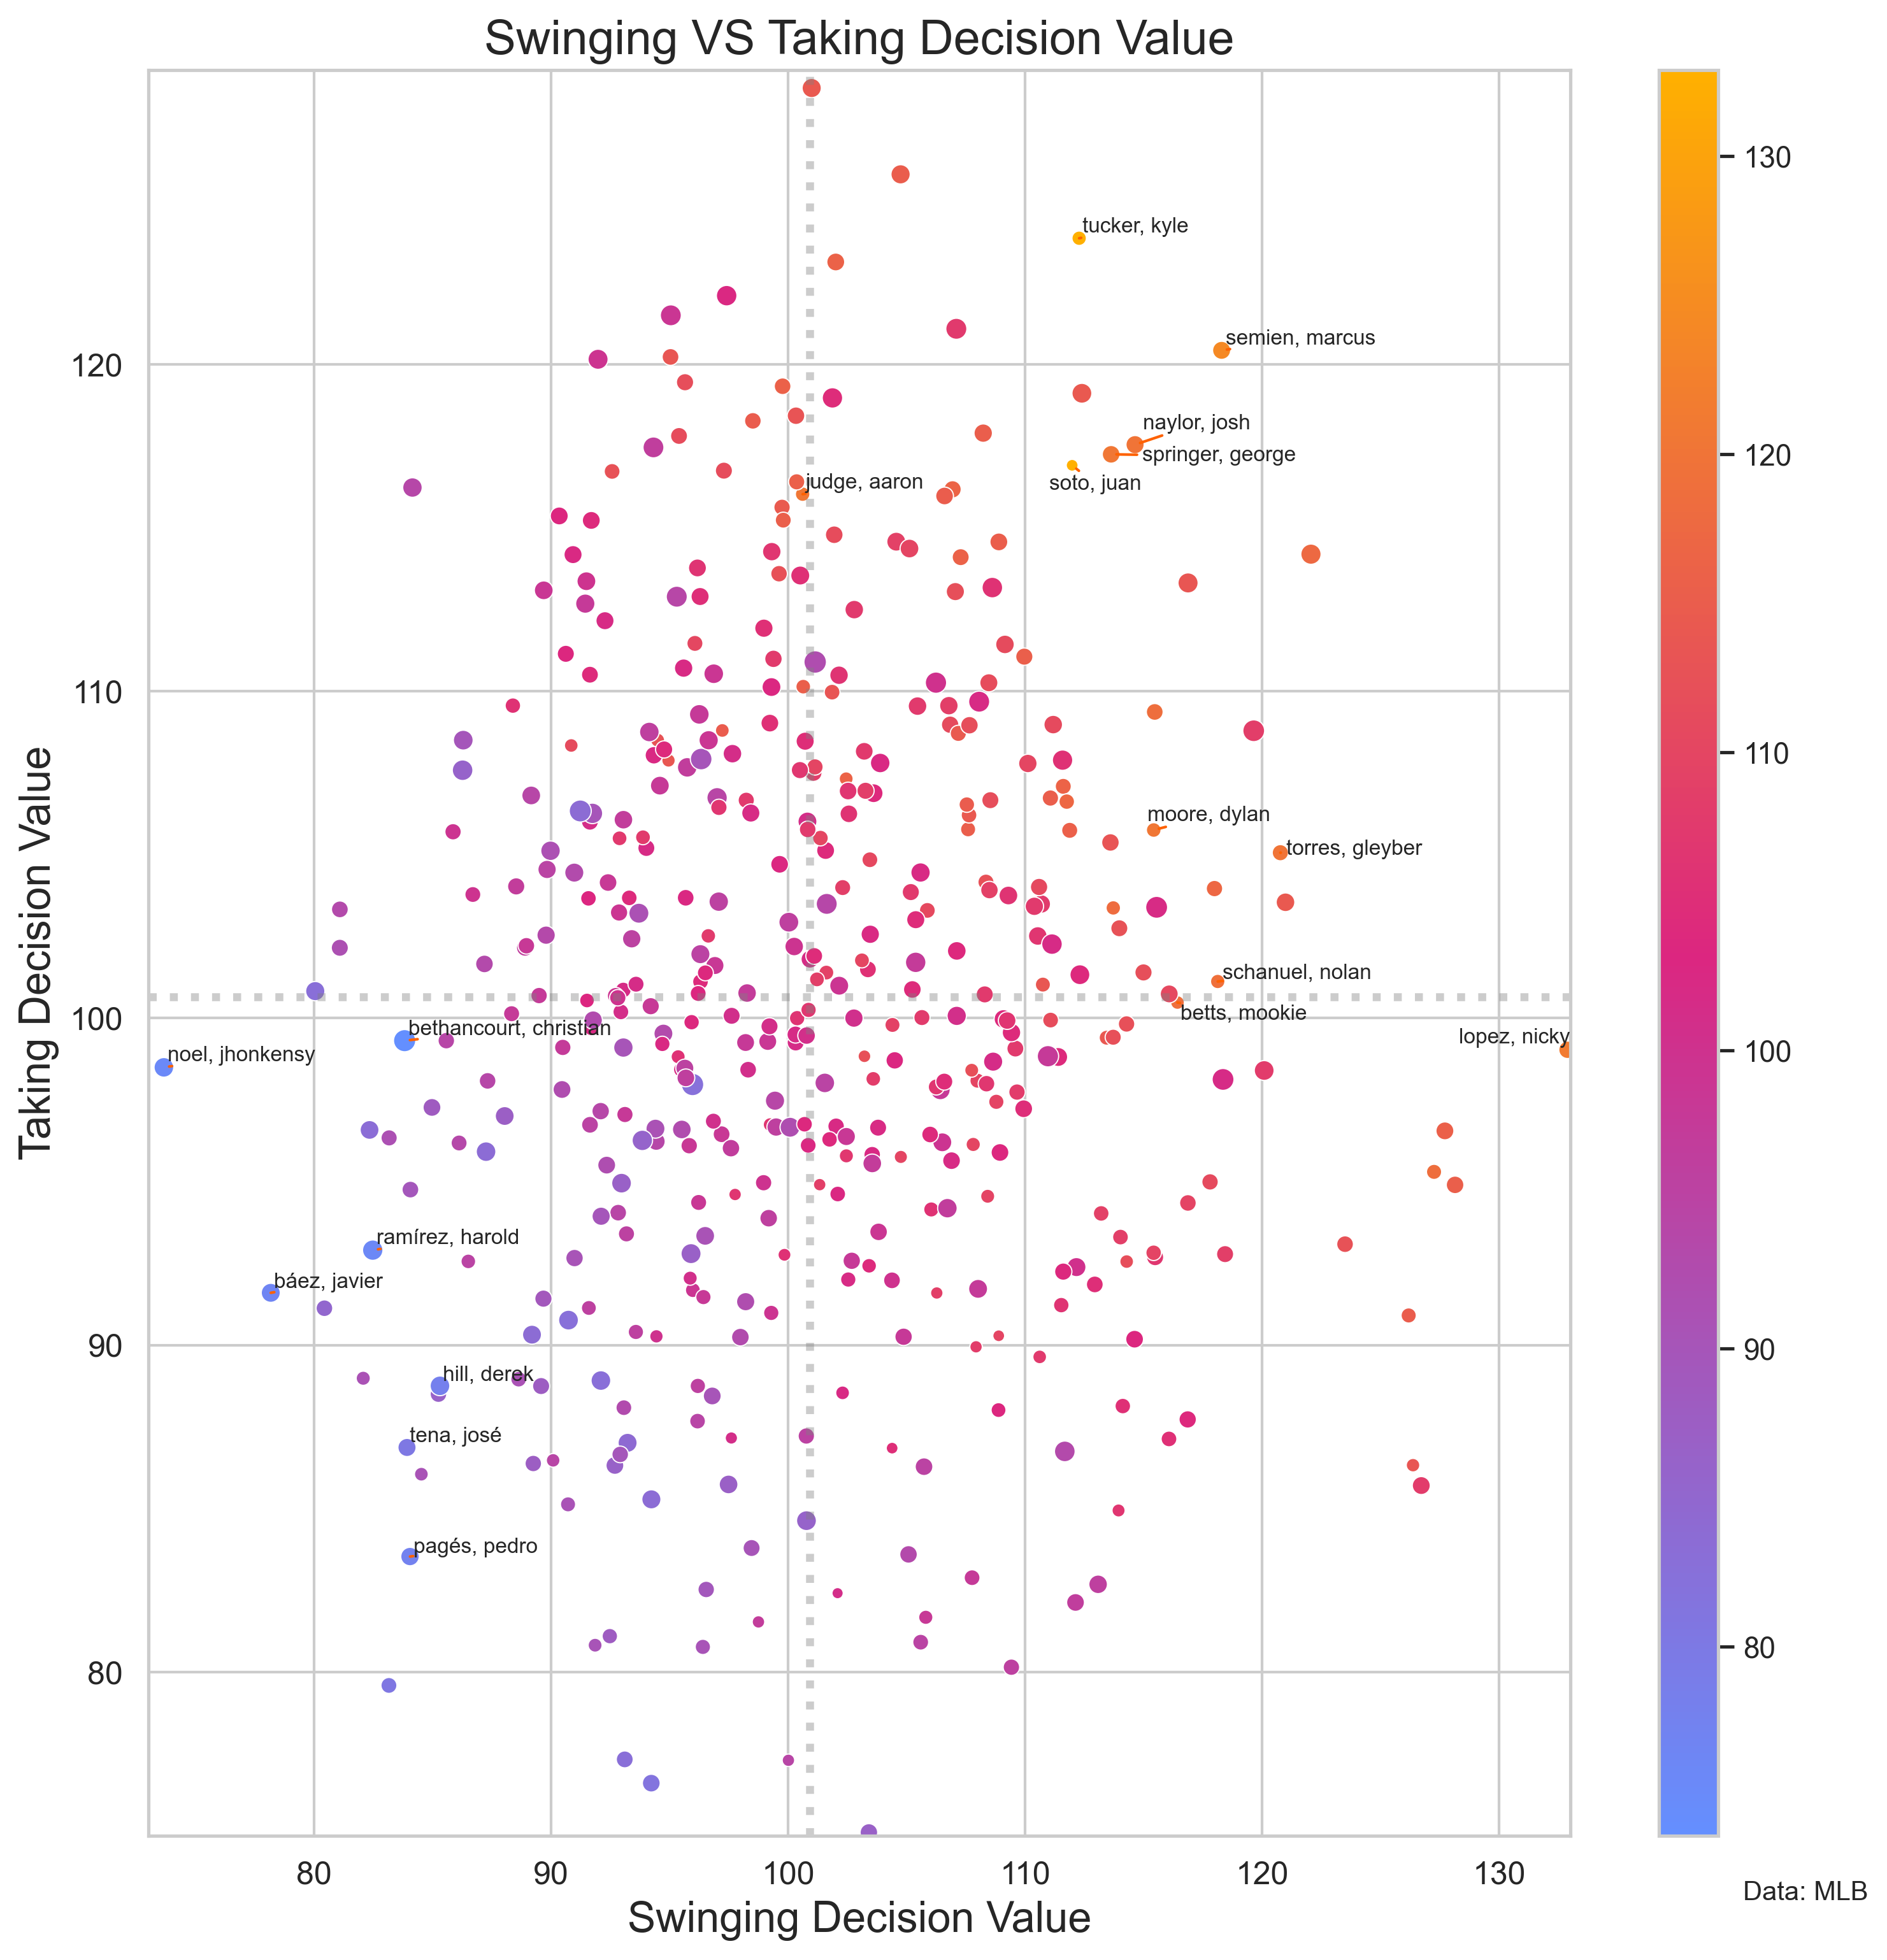

In [97]:
sns.set_theme(style = "whitegrid", palette = "pastel")
fig, ax = plt.subplots(1, 1, figsize = (12, 12), dpi = 300)

cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1], colour_palette[3], colour_palette[0]])
norm = plt.Normalize(min(all_data_2024_swing_plus_no_grouped['decision_value_swing'].min(), all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].min()), 
                     max(all_data_2024_swing_plus_no_grouped['decision_value_swing'].max(), all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].max()))

sns.scatterplot(x = all_data_2024_swing_plus_no_grouped['decision_value_swing'],
                y = all_data_2024_swing_plus_no_grouped['decision_value_no_swing'],
                hue = all_data_2024_swing_plus_no_grouped['decision_value_overall'],
                size = all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing']),
                palette = cmap_hue)

sm = plt.cm.ScalarMappable(cmap = cmap_hue, norm = norm)
cbar = ax.figure.colorbar(sm, ax = ax, orientation = 'vertical', aspect = 30)

ax.hlines(xmin = (math.floor((all_data_2024_swing_plus_no_grouped['decision_value_swing'].min()))),
            xmax = (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_swing'].max()))),
            y = all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].mean(), color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)

ax.vlines(ymin=(math.floor((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].min()))),
            ymax= (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].max()))),
            x = all_data_2024_swing_plus_no_grouped['decision_value_swing'].mean(), color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)



ax.set_xlim((math.floor((all_data_2024_swing_plus_no_grouped['decision_value_swing'].min()))),
            (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_swing'].max()))))


ax.set_ylim((math.floor((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].min()))),
            (math.ceil((all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].max()))))
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.set_xlabel('Swinging Decision Value', fontsize = 16)
ax.set_ylabel('Taking Decision Value', fontsize = 16)
ax.get_legend().remove()

ax.set_title('Swinging VS Taking Decision Value', fontsize = 18)

ts = []


thresh = 117
thresh_2 = 80
for i in range(len(all_data_2024_swing_plus_no_grouped)):
   if (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] >= thresh) or (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] <= thresh_2):
      ts.append(ax.text(x = all_data_2024_swing_plus_no_grouped['decision_value_swing'].values[i],
      y = all_data_2024_swing_plus_no_grouped['decision_value_no_swing'].values[i],
      s = all_data_2024_swing_plus_no_grouped['batter_name_swing'].values[i],
      fontsize = 8))


adjust_text(ts, arrowprops = dict(arrowstyle = "-", color = colour_palette[4], lw = 1), ax = ax)

# ax.text(x = -3.5, y = 3.71, s = f'Min. {min_pitches} Pitches', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))
# ax.text(x = -3.5, y = 3.31, s = f'Point Size Represents Swing%', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))

fig.text(0.875, 0.085, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)

##### According to the chart, a batter’s decision value can be carried by either their swining decision (Nicky Lopez) or their taking decision (Aaron Judge).

Text(0.875, 0.085, 'Data: MLB')

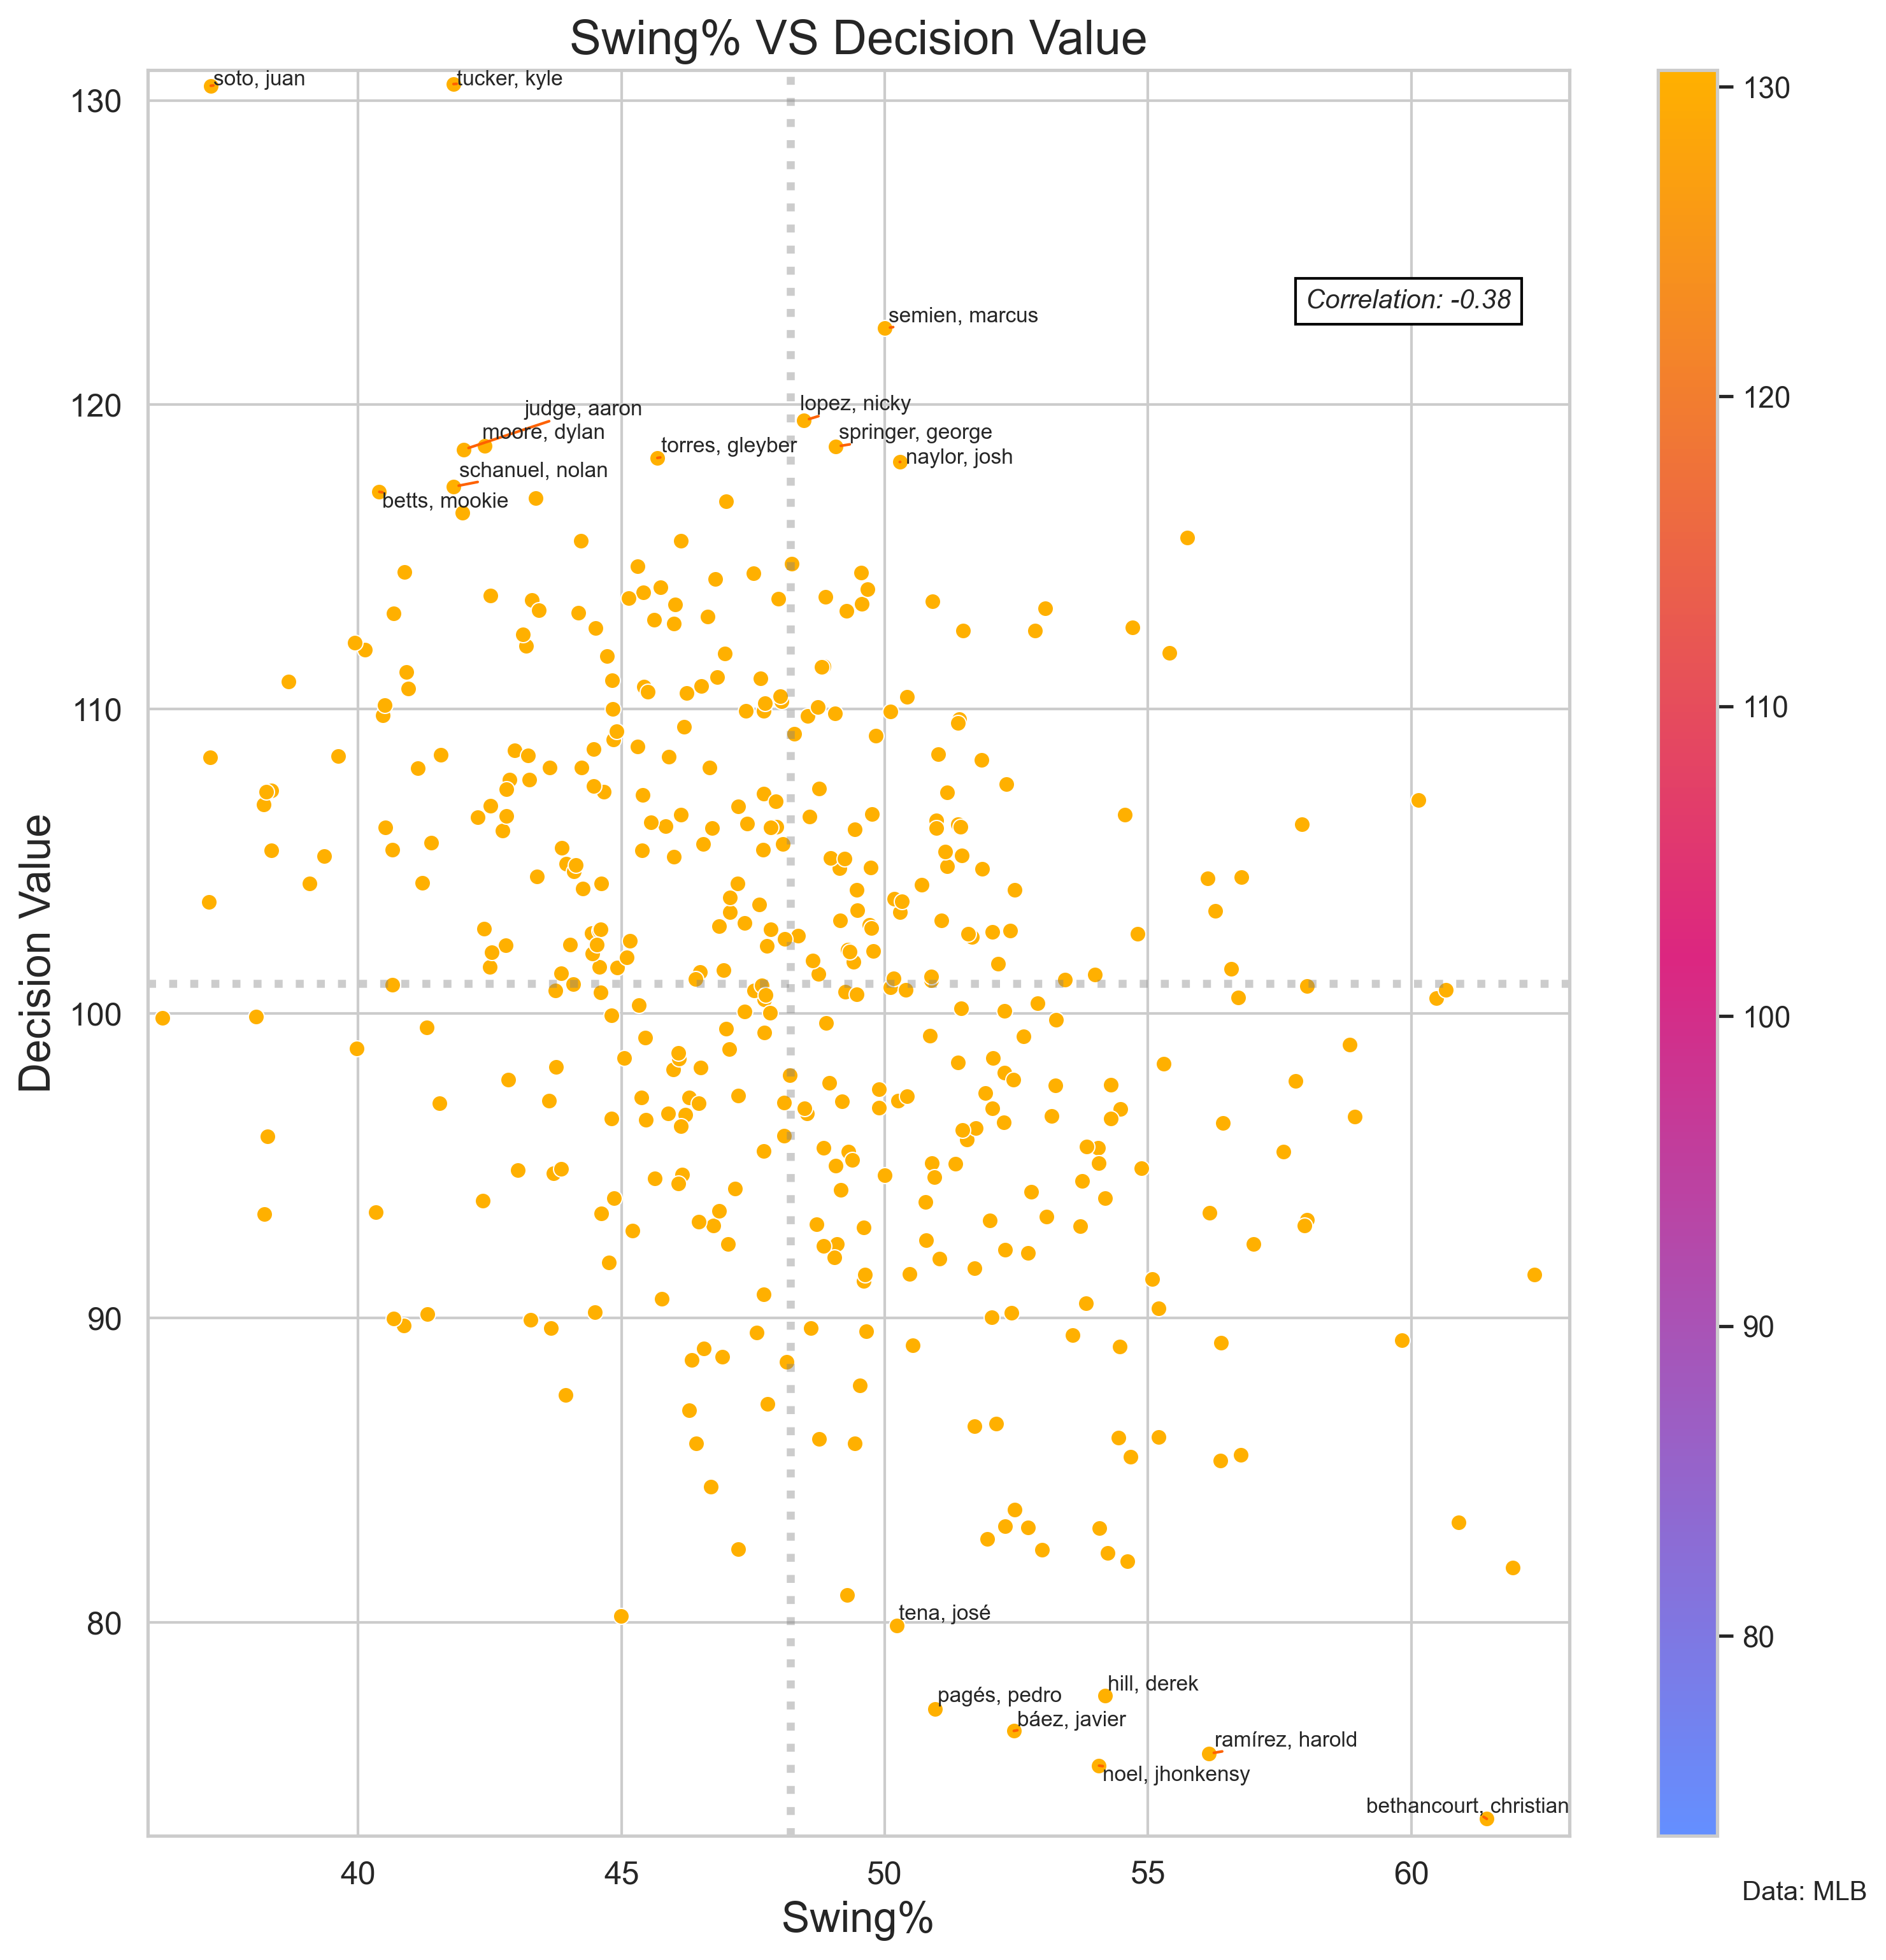

In [98]:
sns.set_theme(style = "whitegrid", palette = "pastel")
fig, ax = plt.subplots(1, 1, figsize = (12, 12), dpi = 300)

cmap_hue = matplotlib.colors.LinearSegmentedColormap.from_list("", [colour_palette[1], colour_palette[3], colour_palette[0]])
norm = plt.Normalize(all_data_2024_swing_plus_no_grouped['decision_value_overall'].min(), all_data_2024_swing_plus_no_grouped['decision_value_overall'].max())

sns.scatterplot(x = all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing']) * 100,
                y = all_data_2024_swing_plus_no_grouped['decision_value_overall'], color = colour_palette[0])

sm = plt.cm.ScalarMappable(cmap = cmap_hue, norm = norm)
cbar  = ax.figure.colorbar(sm, ax = ax, orientation = 'vertical', aspect = 30)

ax.hlines(xmin = (math.floor((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).min() * 100)),
            xmax = (math.ceil((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).max() * 100)),
            y = all_data_2024_swing_plus_no_grouped['decision_value_overall'].mean(), color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)

ax.vlines(ymin = (math.floor(all_data_2024_swing_plus_no_grouped['decision_value_overall'].min())),
            ymax = (math.ceil(all_data_2024_swing_plus_no_grouped['decision_value_overall'].max())),
            x = (all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).mean() * 100, color = 'gray', linewidth = 3, linestyle = 'dotted', alpha = 0.4)

ax.set_xlim((math.floor((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).min() * 100)),
            (math.ceil((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])).max() * 100)))

ax.set_ylim((math.floor(all_data_2024_swing_plus_no_grouped['decision_value_overall'].min())),
            (math.ceil(all_data_2024_swing_plus_no_grouped['decision_value_overall'].max())))
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.set_xlabel('Swing%', fontsize = 16)
ax.set_ylabel('Decision Value', fontsize = 16)

ax.set_title('Swing% VS Decision Value', fontsize = 18)

ts = []

thresh = 117
thresh_2 = 80
for i in range(len(all_data_2024_swing_plus_no_grouped)):
   if (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] >= thresh) or (all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i] <= thresh_2):
      ts.append(ax.text(x = all_data_2024_swing_plus_no_grouped['pitches_swing'].values[i] / (all_data_2024_swing_plus_no_grouped['pitches_swing'].values[i] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'].values[i]) * 100,
      y = all_data_2024_swing_plus_no_grouped['decision_value_overall'].values[i],
      s = all_data_2024_swing_plus_no_grouped['batter_name_swing'].values[i],
      fontsize = 8))

corr_value = np.corrcoef(((all_data_2024_swing_plus_no_grouped['pitches_swing'] / (all_data_2024_swing_plus_no_grouped['pitches_swing'] + all_data_2024_swing_plus_no_grouped['pitches_no_swing'])) * 100, all_data_2024_swing_plus_no_grouped['decision_value_overall']))[0][1]
ax.text(x = 58, y = 123, s = f'Correlation: {corr_value:.2f}',fontsize = 10, fontstyle = 'oblique', va = 'bottom',
        bbox = dict(facecolor = 'white', edgecolor = 'black'))

adjust_text(ts, arrowprops = dict(arrowstyle = "-", color = colour_palette[4], lw = 1), ax = ax)

# ax.text(x = -3.5, y = 3.71, s = f'Min. {min_pitches} Pitches', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))
# ax.text(x = -3.5, y = 3.31, s = f'Point Size Represents Swing%', fontsize = 10, fontstyle = 'oblique', va = 'bottom',
#         bbox = dict(facecolor = 'white', edgecolor = 'black'))

fig.text(0.875, 0.085, "Data: MLB", ha = 'right', va = 'center', fontsize = 10)